# Imports

In [1]:
import pandas as pd
import numpy as np
import os
import sys
import math
import json
import pickle 

import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler

from sklearn.preprocessing import OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.inspection import permutation_importance
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.linear_model import ElasticNet

# Optimization
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
from hyperopt.pyll import scope

## Glossary



- **Solo Queue**. The [**Solo Queue**](https://bloygo.yoigo.com/glossary/soloq-definition/) or **SoloQ** is a game mode in which gamers can **increase their skills by playing solo**. In this way, the SoloQ Challenge is a way to exploit a way of playing that would otherwise be completely overshadowed. It is typical of **League of Legends**, because it is a kind of **purgatory in which the player practices alone** in order to improve their skills.

- **Elo**. The [**Elo**](https://leagueoflegends.fandom.com/wiki/Elo_rating_system#:~:text=A%20person%20with%20a%20higher,in%20relation%20to%20other%20players.) is essentially a player's ranking. It is determined by the win/loss ratio and how many games they have played. In a normal **Queue**, the Elo is hidden from the player and others, but the matchmaking system still uses it to decide the player's opponents. In ranked games, the player's Elo is there for the world to see, with *Iron being the lowest and Challenger being the highest*.

- **Nexus**. The [**Nexus**](https://leagueoflegends.fandom.com/wiki/Nexus) is a structure that serves as the primary objective in all game modes in League of Legends. *The team that destroys the opposing team's Nexus wins the match*.

- **Ward**. Ward is a **guard** in **LoL**. Wards allow you to see beyond the fog of war, which is extremely important for, for example, **knowing whether or not to attack and when is the best time** to do so. The best thing to do if we're not doing very well in the game is to place the wards in our jungle, while if we're overpowered we can risk putting them in the enemy jungle to **see what our opponent is doing**.

- **Minion**. The [**Minions**](https://leagueoflegends.fandom.com/wiki/Minion_(League_of_Legends)) are units that make up the main force sent by the Nexus. They spawn periodically from their Nexus and advance along a lane towards the enemy Nexus, automatically engaging any enemy units or structures they encounter. They are controlled by artificial intelligence and only use basic attacks.

- **CS**. The minion kill count is a recorded score, commonly known as [**Creep Score (CS)**](https://leagueoflegends.fandom.com/wiki/Farming).

- **Buff**. A [**buff**](https://leagueoflegends.fandom.com/wiki/Buff) is any status effect given to a champion or minion that gives them a beneficial boost to their performance. The opposite is called a **debuff**. Buffs can benefit almost any attribute of a character, such as health, mana, attack damage, and ability power, but in some cases they can provide more than just statistical changes.

- **First Blood**. [**First Blood**](https://www.pinnacle.com/en/esports-hub/betting-articles/league-of-legends/betting-on-first-blood/sgajzgnuz8lgxujv) (FB), refers to a team in League of Legends (LoL) that achieves the first kill on an enemy player in a game. Achieving the FB on an opponent is crucial due to the influence it has in the early stages of the game.

- **Champions**. [**Champions**](https://leagueoflegends.fandom.com/wiki/Champion) are player-controlled characters in League of Legends icon.png League of Legends. Each champion possesses unique abilities and attributes.

- **Turrets**. [**Turrets**](https://leagueoflegends.fandom.com/wiki/Turret) (Turrets in English), also called towers, are strong fortifications that attack enemy units on sight. Turrets are a core component of League of Legends. They deal damage to enemies and provide vision to their team, allowing them to better control the battlefield. Turrets target one unit at a time and deal heavy damage. Teams must destroy enemy turrets to push their assault into enemy territory.

# Data preparation
In this section, the dataset contained in the high_diamond_ranked_10min.csv file will be loaded. A quick analysis of the information contained in the dataset will be performed.

The dataset is a csv file and to read it we will use the read.csv function. The information read will be stored in the variable data.raw.

In [2]:
BASE_DIR = ".."
DATA_DIR = f"{BASE_DIR}/data"
MODELS_DIR = f"{BASE_DIR}/models"
RAW_DATA_DIR = f"{DATA_DIR}/raw"
PREPRO_DATA_DIR = f"{DATA_DIR}/prepro"

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(PREPRO_DATA_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

# Dataset Raw
RAW_DATASET_FILE = f"{RAW_DATA_DIR}/high_diamond_ranked_10min.csv"
# Dataset Preproc
CLEAN_DATASET_FILE = f"{PREPRO_DATA_DIR}/high_diamond_ranked_10min_clean.csv"
# Dataset Preproc + feature selecction
FS_CLEAN_DATASET_FILE = f"{PREPRO_DATA_DIR}/high_diamond_ranked_10min_clean_fs.csv"

# Model Random Forest
BASE_MODEL_RF_FILE = f"{MODELS_DIR}/base_model_rf.pkl"
BEST_MODEL_RF_FILE = f"{MODELS_DIR}/best_model_rf.pkl"
BEST_PARAMS_RF_FILE = f"{MODELS_DIR}/best_param_rf.json"
# Model XGBoost
BASE_MODEL_XGB_FILE = f"{MODELS_DIR}/base_model_xgb.pkl"
BEST_MODEL_XGB_FILE = f"{MODELS_DIR}/best_model_xgb.pkl"
BEST_PARAMS_XGB_FILE = f"{MODELS_DIR}/best_param_xgb.json"

In [3]:
!ls -lh "{RAW_DATA_DIR}"
!ls -lh "{PREPRO_DATA_DIR}"
!ls -lh "{MODELS_DIR}"

total 2,8M
-rw-rw-r-- 1 aztleclan aztleclan 1,4M abr 13  2020 high_diamond_ranked_10min.csv
-rw-rw-r-- 1 aztleclan aztleclan 283K nov 26 01:08 high_diamond_ranked_10min_raw_test.csv
-rw-rw-r-- 1 aztleclan aztleclan 1,2M nov 26 01:08 high_diamond_ranked_10min_raw_train.csv
total 1,5M
-rw-rw-r-- 1 aztleclan aztleclan 504K nov 26 01:20 high_diamond_ranked_10min_clean.csv
-rw-rw-r-- 1 aztleclan aztleclan 441K nov 26 01:08 high_diamond_ranked_10min_full_train_clean.csv
-rw-rw-r-- 1 aztleclan aztleclan 109K nov 26 01:08 high_diamond_ranked_10min_test_clean.csv
-rw-rw-r-- 1 aztleclan aztleclan 331K nov 26 01:08 high_diamond_ranked_10min_train_clean.csv
-rw-rw-r-- 1 aztleclan aztleclan 110K nov 26 01:08 high_diamond_ranked_10min_valid_clean.csv
total 1,9M
-rw-rw-r-- 1 aztleclan aztleclan 6,2K nov 26 01:08 base_rf_eval.csv
-rw-rw-r-- 1 aztleclan aztleclan 143K nov 26 01:08 base_rf_eval_plot.png
-rw-rw-r-- 1 aztleclan aztleclan 422K nov 26 01:08 base_rf.pkl
-rw-rw-r-- 1 aztleclan aztleclan 6,2K 

In [4]:
!head -5 "{RAW_DATASET_FILE}"

gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,blueTowersDestroyed,blueTotalGold,blueAvgLevel,blueTotalExperience,blueTotalMinionsKilled,blueTotalJungleMinionsKilled,blueGoldDiff,blueExperienceDiff,blueCSPerMin,blueGoldPerMin,redWardsPlaced,redWardsDestroyed,redFirstBlood,redKills,redDeaths,redAssists,redEliteMonsters,redDragons,redHeralds,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
4519157822,0,28,2,1,9,6,11,0,0,0,0,17210,6.6,17039,195,36,643,-8,19.5,1721.0,15,6,0,6,9,8,0,0,0,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
4523371949,0,12,1,0,5,5,5,0,0,0,0,14712,6.6,16265,174,43,-2908,-1173,17.4,1471.2,12,1,1,5,5,2,2,1,1,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
4521474530,0,15,0,0,7,11,4,1,1,0,0,16113,6.4,16221,186,46,-1172,-1033,18.6,1611.3,15,3,1,11,7,14,0,0,0,0,172

In [5]:
data_raw = pd.read_csv(RAW_DATASET_FILE)

In [6]:
data_raw.head(5)

,gameId,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
0,4519157822,0,28,2,1,9,6,11,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
1,4523371949,0,12,1,0,5,5,5,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
2,4521474530,0,15,0,0,7,11,4,1,1,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
3,4524384067,0,43,1,0,4,5,5,1,0,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4,4436033771,0,75,4,0,6,6,6,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4


In [7]:
data_raw.shape

(9879, 40)

In [8]:
data_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9879 entries, 0 to 9878
Data columns (total 40 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gameId                        9879 non-null   int64  
 1   blueWins                      9879 non-null   int64  
 2   blueWardsPlaced               9879 non-null   int64  
 3   blueWardsDestroyed            9879 non-null   int64  
 4   blueFirstBlood                9879 non-null   int64  
 5   blueKills                     9879 non-null   int64  
 6   blueDeaths                    9879 non-null   int64  
 7   blueAssists                   9879 non-null   int64  
 8   blueEliteMonsters             9879 non-null   int64  
 9   blueDragons                   9879 non-null   int64  
 10  blueHeralds                   9879 non-null   int64  
 11  blueTowersDestroyed           9879 non-null   int64  
 12  blueTotalGold                 9879 non-null   int64  
 13  blu

In [9]:
len(data_raw["gameId"]), len(data_raw["gameId"].unique())

(9879, 9879)

We check if there are duplicate records in the data.frame. To do this we can use the duplicate function.

In [10]:
# Ver si hay filas duplicadas
duplicates = data_raw.duplicated()

# Mostrar las filas duplicadas (si existen)
print(f"duplicates: {duplicates.sum()}")

duplicates: 0


Let's check if there are columns in the data.frame that have nulls.

In [11]:
# Contar cuántos NaN hay en cada columna
nan_por_columna = data_raw.isna().sum()

# Convertir el resultado a un DataFrame con las columnas como índice
nan_por_columna_df = nan_por_columna.reset_index()
nan_por_columna_df.columns = ['Columna', 'Num. NA']

# Mostrar el DataFrame resultante
print(nan_por_columna_df)

                         Columna  Num. NA
0                         gameId        0
1                       blueWins        0
2                blueWardsPlaced        0
3             blueWardsDestroyed        0
4                 blueFirstBlood        0
5                      blueKills        0
6                     blueDeaths        0
7                    blueAssists        0
8              blueEliteMonsters        0
9                    blueDragons        0
10                   blueHeralds        0
11           blueTowersDestroyed        0
12                 blueTotalGold        0
13                  blueAvgLevel        0
14           blueTotalExperience        0
15        blueTotalMinionsKilled        0
16  blueTotalJungleMinionsKilled        0
17                  blueGoldDiff        0
18            blueExperienceDiff        0
19                  blueCSPerMin        0
20                blueGoldPerMin        0
21                redWardsPlaced        0
22             redWardsDestroyed  

As can be seen in the dataset, there are no duplicate records or columns with null values.

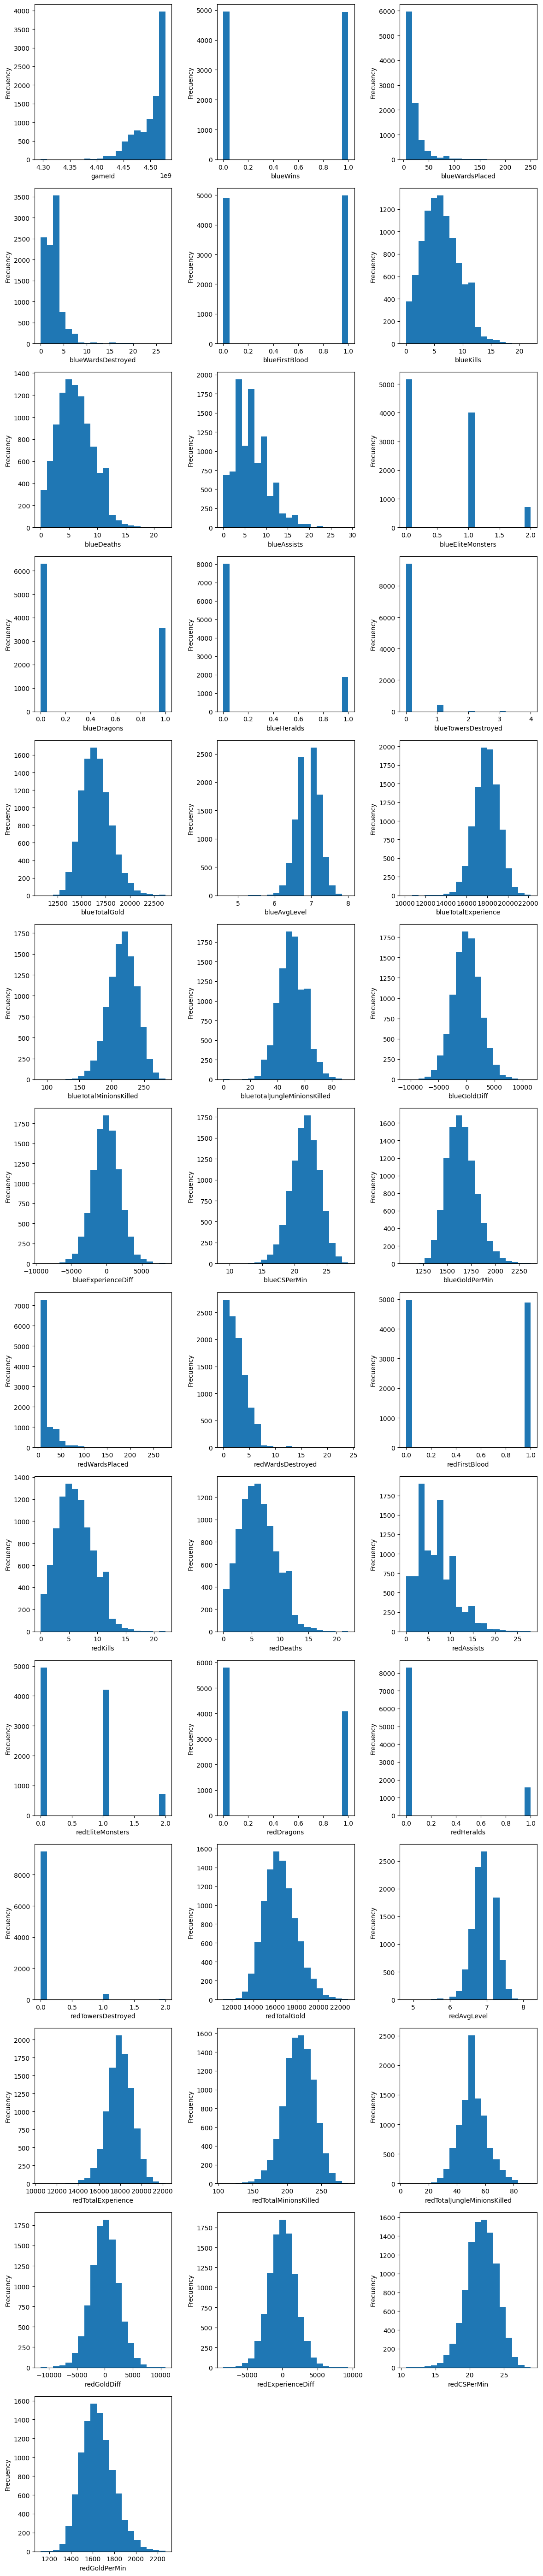

In [12]:
# Suponiendo que `df` es un DataFrame de pandas
# Filtrar las columnas numéricas
df_cols_num = data_raw.select_dtypes(include=['number']).columns

# Calcular el número de filas necesarias para 3 columnas por fila
num_rows = int(np.ceil(len(df_cols_num) / 3))

# Ajustar el tamaño de la figura en función del número de filas
plt.figure(figsize=(12, 4 * num_rows))  # Altura ajustada dependiendo del número de filas

# Plot histograms
for i, column in enumerate(df_cols_num):
    plt.subplot(num_rows, 3, i + 1)  # Crear subgráficos con 3 columnas por fila
    plt.hist(data_raw[column], bins=20)  # Histograma de cada columna
    plt.title('')  # No se establece título
    plt.xlabel(column)  # Etiqueta para el eje X
    plt.ylabel('Frecuency')

plt.tight_layout()  # Ajustar los subgráficos para que no se solapen
plt.show()

# Data Wrangling
In this section we are going to carry out the data manipulation or wrangling process (known as data wrangling) to make it more concise and better structured. Data wrangling is nothing more than the action of cleaning, unifying, consolidating and normalizing data so that it can be used and extract valuable information for its real use. Data wrangling is important because, if done correctly, it will improve the results and training speed of our ML algorithms later on. Part of this process is to eliminate unnecessary columns.

All data cleaning actions will be saved in the variable data.clean.

## Simple Variables

The only column that we seem to be able to remove right away is the gameId column. This column corresponds to the League of Legends API reference for the game. Using this number, we could request more information from the API. Since we will only be working with the data in the dataset, we can remove this column since it does not affect whether a game is won or not.

However, we are going to use the gameId attribute as the row name since it is unique and can make error analysis easier for us later.

In [13]:
# Assuming data_raw is a pandas DataFrame
data_column_rowname = "gameId"

# Convert the 'gameId' column into the row index and remove it from the columns
data_clean = data_raw.set_index(data_column_rowname)

Let's look at about 10 records to check that the rows have the value of the gameId column as their name.

In [14]:
# Display the cleaned DataFrame
data_clean.head(10)

,blueWins,blueWardsPlaced,blueWardsDestroyed,blueFirstBlood,blueKills,blueDeaths,blueAssists,blueEliteMonsters,blueDragons,blueHeralds,...,redTowersDestroyed,redTotalGold,redAvgLevel,redTotalExperience,redTotalMinionsKilled,redTotalJungleMinionsKilled,redGoldDiff,redExperienceDiff,redCSPerMin,redGoldPerMin
gameId,,,,,,,,,,,,,,,,,,,,,
4519157822,0,28,2,1,9,6,11,0,0,0,...,0,16567,6.8,17047,197,55,-643,8,19.7,1656.7
4523371949,0,12,1,0,5,5,5,0,0,0,...,1,17620,6.8,17438,240,52,2908,1173,24.0,1762.0
4521474530,0,15,0,0,7,11,4,1,1,0,...,0,17285,6.8,17254,203,28,1172,1033,20.3,1728.5
4524384067,0,43,1,0,4,5,5,1,0,1,...,0,16478,7.0,17961,235,47,1321,7,23.5,1647.8
4436033771,0,75,4,0,6,6,6,0,0,0,...,0,17404,7.0,18313,225,67,1004,-230,22.5,1740.4
4475365709,1,18,0,0,5,3,6,1,1,0,...,0,15201,7.0,18060,221,59,-698,-101,22.1,1520.1
4493010632,1,18,3,1,7,6,7,1,1,0,...,0,14463,6.4,15404,164,35,-2411,-1563,16.4,1446.3
4496759358,0,16,2,0,5,13,3,0,0,0,...,0,17920,6.6,16938,157,54,2615,800,15.7,1792.0
4443048030,0,16,3,0,7,7,8,0,0,0,...,0,18380,7.2,19298,240,53,1979,771,24.0,1838.0


In League of Legend, the team that achieves the first kill of the enemy is recorded as a logical value, this action is known as FirstBlood (FB). In each match, only one of the teams has caused the FB. As we can deduce, the FB of the blue team is the opposite of the FB of the red team. Therefore, we can eliminate the variable redFirstBlood since it is redundant.

In [15]:
# Remove the 'redFirstBlood' column from data_clean
data_clean = data_clean.drop(columns=['redFirstBlood'])

## Aggregative variables

Our dataset is composed of several aggregative and comparative variables. Such as, the difference in the amount of gold between teams, how many minions were killed per minute or the average level.

It seems that certain columns can be a direct linear combination of other columns. For example, total experience (blueTotalExperience/redTotalExperience) and average level (blueAvgLevel/redAvgLevel) should be directly related. Also, minions killed per minute (blueCSPerMin/redCSPerMin) and total minions killed (blueTotalMinionsKilled/redTotalMinionsKilled) should be directly related. This is the same as for total gold (blueTotalGold/redTotalGold) and gold per minute (blueGoldPerMin/redGoldPerMin). So, we want to see how to get rid of this redundant information

First, let's take a closer look at the total experience and the average level and see if we can clearly tell that they are linearly correlated, and if so, remove one of them.

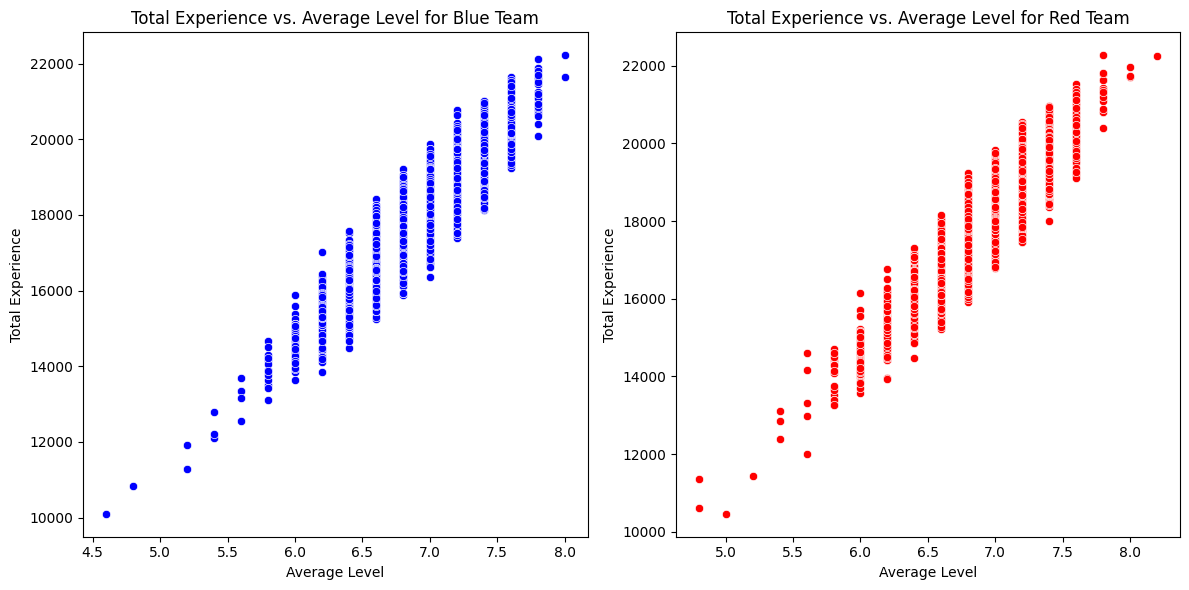

In [16]:
# Set up the figure and axes for side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot: blueAvgLevel vs blueTotalExperience (Blue Team)
sns.scatterplot(data=data_clean, x='blueAvgLevel', y='blueTotalExperience', color='blue', ax=axes[0])
axes[0].set_title("Total Experience vs. Average Level for Blue Team")
axes[0].set_xlabel("Average Level")
axes[0].set_ylabel("Total Experience")

# Plot: redAvgLevel vs redTotalExperience (Red Team)
sns.scatterplot(data=data_clean, x='redAvgLevel', y='redTotalExperience', color='red', ax=axes[1])
axes[1].set_title("Total Experience vs. Average Level for Red Team")
axes[1].set_xlabel("Average Level")
axes[1].set_ylabel("Total Experience")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

As we can see, there is obviously a positive linear relationship between total experience and average level. Indeed, it seems that they are probably the same, it's just that the average level seems clustered and therefore less accurate. For this reason, we are going to remove the average level for both the `blue` and `red` team.

In [17]:
# Remove columns: blueAvgLevel and redAvgLevel from data_clean
data_clean = data_clean.drop(columns=['blueAvgLevel', 'redAvgLevel'])

Now let's take a look at whether there is a correlation between average CS per minute and total minions killed. Likewise, as we did before we test this assumption.

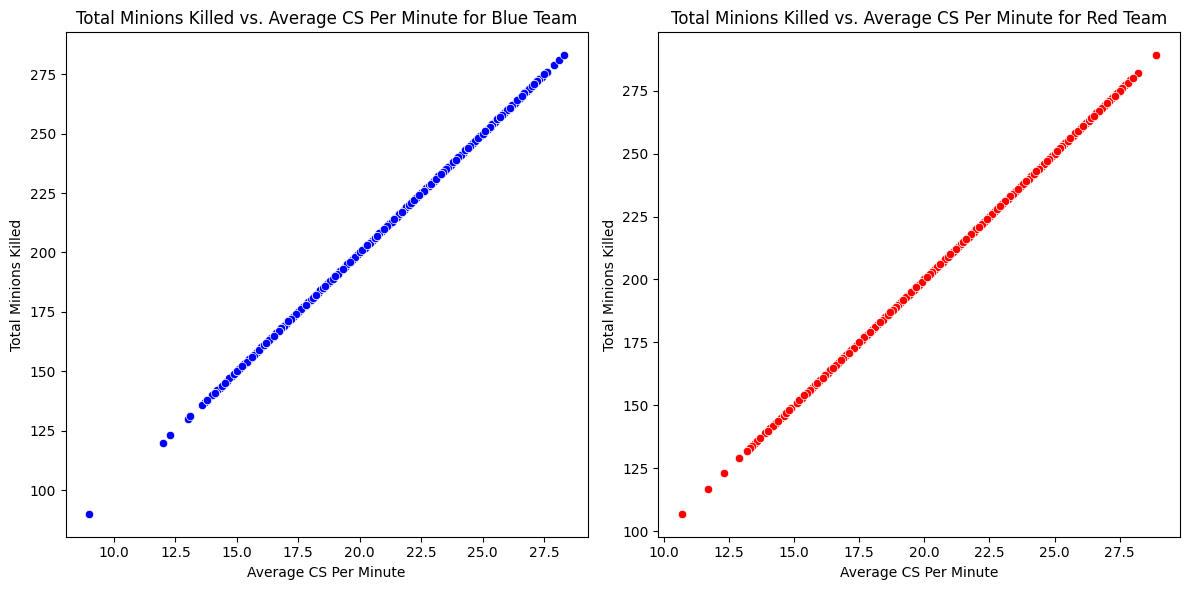

In [18]:
# Set up the figure and axes for side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot: blueCSPerMin Vs blueTotalMinionsKilled (Blue Team)
sns.scatterplot(data=data_clean, x='blueCSPerMin', y='blueTotalMinionsKilled', color='blue', ax=axes[0])
axes[0].set_title("Total Minions Killed vs. Average CS Per Minute for Blue Team")
axes[0].set_xlabel("Average CS Per Minute")
axes[0].set_ylabel("Total Minions Killed")

# Plot: redCSPerMin Vs redTotalMinionsKilled (Red Team)
sns.scatterplot(data=data_clean, x='redCSPerMin', y='redTotalMinionsKilled', color='red', ax=axes[1])
axes[1].set_title("Total Minions Killed vs. Average CS Per Minute for Red Team")
axes[1].set_xlabel("Average CS Per Minute")
axes[1].set_ylabel("Total Minions Killed")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

You can see that this is a linear combination. Since it forms a perfect line, if we look at the axes we can determine that the average CS per minute is probably just the total minions divided by 10 (since this is the first 10 minutes of the game). For this reason, we're going to remove one of these features.

Since it's a perfect linear combination, it shouldn't matter which feature we remove here, but we're going to remove the average CS per minute feature for both red and blue. This is because we'll be doing our own data scaling later on and it might be a little better to start with the original total CS values.

In [19]:
# Remove columns: blueCSPerMin and redCSPerMin from data_clean
data_clean = data_clean.drop(columns=['blueCSPerMin', 'redCSPerMin'])

Finally, let’s take a look at Total Gold vs Gold per Minute. We assume this will behave very similarly to Total CS vs Average CS, but we won’t know until we see the chart.

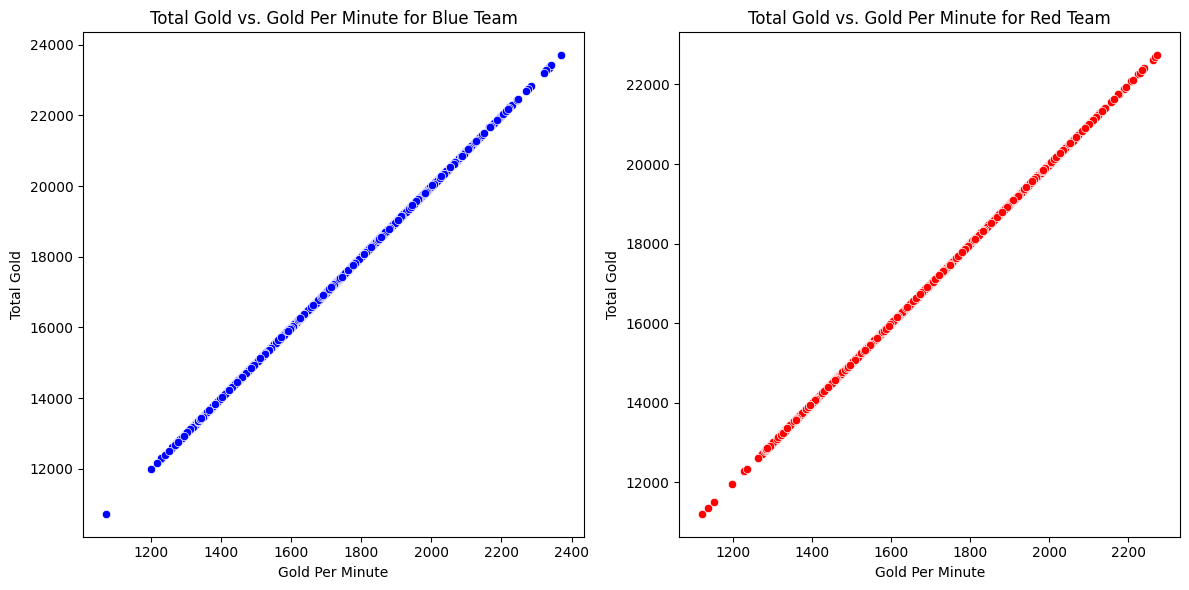

In [20]:
# Set up the figure and axes for side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))  # 1 row, 2 columns

# Plot: blueGoldPerMin vs blueTotalGold (Blue Team)
sns.scatterplot(data=data_clean, x='blueGoldPerMin', y='blueTotalGold', color='blue', ax=axes[0])
axes[0].set_title("Total Gold vs. Gold Per Minute for Blue Team")
axes[0].set_xlabel("Gold Per Minute")
axes[0].set_ylabel("Total Gold")

# Plot: redGoldPerMin vs redTotalGold (Red Team)
sns.scatterplot(data=data_clean, x='redGoldPerMin', y='redTotalGold', color='red', ax=axes[1])
axes[1].set_title("Total Gold vs. Gold Per Minute for Red Team")
axes[1].set_xlabel("Gold Per Minute")
axes[1].set_ylabel("Total Gold")

# Adjust layout and show the plots
plt.tight_layout()
plt.show()

Again, these columns are perfect linear combinations, with the gold per minute appearing to be the total gold divided by 10. For exactly the same reason as above, we're going to remove the gold per minute for both the red and blue teams.

In [21]:
# Remove columns: blueGoldPerMin and redGoldPerMin from data_clean
data_clean = data_clean.drop(columns=['blueGoldPerMin', 'redGoldPerMin'])

## Additive Variables

There are also variables in the dataset that are a combination of other variables: sums or differences. In the case of differences, we have two cases related to gold and experience. First, we have the difference in the amount of gold between teams. It can be observed that the difference in the amount of gold of the blue team (**blueGoldDIff**) is opposite to the difference in the amount of gold of the red team (**redGoldDIff**).

$$blueGoldDiff = blueTotalGold - redTotalGold$$

$$redGoldDiff = redTotalGold - blueTotalGold$$

$$redGoldDiff = -blueGoldDiff$$

Therefore, it is not necessary to have so much redundant information and we can eliminate the variable **redGoldDiff**.

Secondly, we have the difference in experience between teams. It can also be observed that the difference in experience of the blue team (**blueExperienceDiff**) is opposite to the difference in experience of the red team (**redExperienceDiff**).

$$blueExperienceDiff = blueTotalExperience - redTotalExperience$$

$$redExperienceDiff = redTotalExperience - blueTotalExperience$$

$$blueExperienceDiff = -redExperienceDiffs$$

Similarly, it is not necessary to have so much redundant information and we can also remove the variable **redExperienceDiff**.

We can also get rid of the variables **redTotalExperience** and **blueTotalExperience** since we have **blueExperienceDiff** which already takes into account the information from both variables and displays the data in a better and cleaner way. This same reasoning is applicable to the variables blueTotalGold and redTotalGold so we will remove them as well.

In [22]:
# blueGoldDiff == -redGoldDiff
assert (data_raw['blueGoldDiff'] == -data_raw['redGoldDiff']).all(), "blueGoldDiff != -redGoldDiff"

# redGoldDiff = redTotalGold - blueTotalGold
assert (data_raw['redTotalGold'] - data_raw['blueTotalGold'] == data_raw['redGoldDiff']).all(), "redGoldDiff != redTotalGold - blueTotalGold"

# blueGoldDiff = blueTotalGold - redTotalGold
assert (data_raw['blueTotalGold'] - data_raw['redTotalGold'] == data_raw['blueGoldDiff']).all(), "blueGoldDiff != blueTotalGold - redTotalGold"

# blueExperienceDiff == -redExperienceDiff
assert (data_raw['blueExperienceDiff'] == -data_raw['redExperienceDiff']).all(), "blueExperienceDiff != -redExperienceDiff"

# blueExperienceDiff == blueTotalExperience - redTotalExperience
assert (data_raw['blueExperienceDiff'] == (data_raw['blueTotalExperience'] - data_raw['redTotalExperience'])).all(), "blueExperienceDiff != blueTotalExperience - redTotalExperience"

# redExperienceDiff == redTotalExperience - blueTotalExperience
assert (data_raw['redExperienceDiff'] == (data_raw['redTotalExperience'] - data_raw['blueTotalExperience'])).all(), "redExperienceDiff != redTotalExperience - blueTotalExperience"

# Drop columns: redGoldDiff, redExperienceDiff, blueTotalExperience, redTotalExperience, blueTotalGold, redTotalGold
data_clean = data_clean.drop(columns=['redGoldDiff', 'redExperienceDiff', 'blueTotalExperience', 'redTotalExperience', 'blueTotalGold', 'redTotalGold'])


There are also variables in the dataset that are a combination of others. For example, the number of elite monsters is the sum of the number of **dragons** (blueDragons/redDragons) and **heralds** (redDragons/redHeralds) that a team has killed.

$$blueEliteMonsters = blueDragons + blueHeralds$$

$$redEliteMonsters = redDragons + redHeralds$$

So since we already have two variables for separate epic monsters, there is no reason to keep the total count for all of them together.

In [23]:
# blueEliteMonsters == blueDragons + blueHeralds
assert (data_raw['blueEliteMonsters'] == data_raw['blueDragons'] + data_raw['blueHeralds']).all(), "blueEliteMonsters != blueDragons + blueHeralds"

# redEliteMonsters == redDragons + redHeralds
assert (data_raw['redEliteMonsters'] == data_raw['redDragons'] + data_raw['redHeralds']).all(), "redEliteMonsters != redDragons + redHeralds"

# Drop columns: blueEliteMonsters and redEliteMonsters
data_clean = data_clean.drop(columns=['blueEliteMonsters', 'redEliteMonsters'])

## KDA

In **League Of Legends** (LoL) there is an average that takes into account the performance of players during the game to determine their **level and individual skill as a player**, and in LoL this would be the **KDA**.

The **KDA**, in a nutshell, is a score based on the **kills, deaths, and assists** that a player has had during the game, as indicated by its acronym from English: ***Kill Death Assist*** (kills, deaths, assists).

With the **KDA** you can commonly tell how skilled and capable a player is, and regardless of who you are, **professional or amateur player**, this score is the purest reflection of how good a player you are. If you have a remarkably bad average KDA over a long series of games, that probably indicates that you die too much.

To **calculate a player's KDA** in LoL, it is necessary to take into account the three main factors that are part of this equation: **kills, deaths, and assists**.

$$
KDA = \frac{Kills + Assists}{Deaths }
$$

There is one subtlety to this that I will mention before we get into it. If the kills are 0, that will be a problem since we would be trying to divide by 0. So before the calculation, we need to make sure that instead of dividing by 0, we divide by 1.

Once we calculate the **KDA** for each team, we will subtract the teams' KDAs to get the KDA difference, we will save this calculation in the variable **blueKDADiff**.

This way instead of having two variables associated with the KDA we will keep only one, their difference. Additionally, we will remove the information regarding kills (**blueKills**/**redKills**), deaths (**blueDeaths**/**redDeaths**) and assists (**blueAssists**/**redAssists**) which will be redundant.

In [24]:
# Define the KDA calculation function
def lol_kda(kills, assists, deaths):
    kde = (kills + assists) / deaths.replace(0, 1)  # Avoid division by zero
    return kde

# Calculate the KDA difference
data_clean['blueKDADiff'] = lol_kda(data_clean['blueKills'], 
                                    data_clean['blueAssists'], 
                                    data_clean['blueDeaths']) - \
                            lol_kda(data_clean['redKills'], 
                                    data_clean['redAssists'], 
                                    data_clean['redDeaths'])

# Drop the columns related to kills, assists, and deaths
data_clean = data_clean.drop(columns=['blueKills', 'blueAssists', 'blueDeaths', 
                                      'redKills', 'redAssists', 'redDeaths'])

We have seen that one way to simplify our dataset has been to remove the total count for each team (blue or red) and only keep the differences between these counts.

This can be done on the *total minions killed* (CS) and the *total minions killed in the jungle* (JungleCS). At the end of the game we are more interested in the difference between CS of each team than the total CS of each team separately. This also applies to JungleCS.

Therefore we created the variables **blueCSDiff** and **blueJGCSDiff** that store the differences of **CS** and **JungleCS** respectively. In addition, we remove the variables of *CS* ( **blueTotalMinionsKilled**/**redTotalMinionsKilled**) and *JungleCS* (**blueTotalJungleMinionsKilled**/ **redTotalJungleMinionsKilled**).

In [25]:
# Calculate the difference between the teams' total minions killed
data_clean['blueCSDiff'] = data_clean['blueTotalMinionsKilled'] - data_clean['redTotalMinionsKilled']

# Calculate the difference between the teams' total jungle minions killed
data_clean['blueJGCSDiff'] = data_clean['blueTotalJungleMinionsKilled'] - data_clean['redTotalJungleMinionsKilled']

# Drop the columns no longer needed: blueTotalMinionsKilled, redTotalMinionsKilled,
# blueTotalJungleMinionsKilled, and redTotalJungleMinionsKilled
data_clean = data_clean.drop(columns=['blueTotalMinionsKilled', 'redTotalMinionsKilled', 
                                      'blueTotalJungleMinionsKilled', 'redTotalJungleMinionsKilled'])

Based on the above analysis, we can do the same with each team's total wards and wards destroyed counts. Remember that wards let us see beyond the fog of war. So which team has more vision is more important in determining who will win than simply knowing how much vision each team has.

Therefore, we created the variables **blueWardDiff** and **blueDestWardDiff** that hold the differences in **wards** and **wards destroyed** respectively. We also removed the variables for *wards* ( **blueWardsPlaced**/**redWardsPlaced**) and *wards destroyed* (**blueWardsDestroyed**/**redWardsDestroyed**).

In [26]:
# Calculate the difference between the teams' wards placed
data_clean['blueWardDiff'] = data_clean['blueWardsPlaced'] - data_clean['redWardsPlaced']

# Calculate the difference between the teams' wards destroyed
data_clean['blueDestWardDiff'] = data_clean['blueWardsDestroyed'] - data_clean['redWardsDestroyed']

# Drop the columns no longer needed: blueWardsPlaced, redWardsPlaced,
# blueWardsDestroyed, and redWardsDestroyed
data_clean = data_clean.drop(columns=['blueWardsPlaced', 'redWardsPlaced', 
                                      'blueWardsDestroyed', 'redWardsDestroyed'])

Once all the previous work has been done, let's inspect how our dataset has turned out.

In [27]:
# Display the dimensions of the DataFrame (rows, columns)
print("Dimensions of the dataset:", data_clean.shape)

# Show the first 10 records
print("First 10 records:")
data_clean.head(10)

Dimensions of the dataset: (9879, 15)
First 10 records:


,blueWins,blueFirstBlood,blueDragons,blueHeralds,blueTowersDestroyed,blueGoldDiff,blueExperienceDiff,redDragons,redHeralds,redTowersDestroyed,blueKDADiff,blueCSDiff,blueJGCSDiff,blueWardDiff,blueDestWardDiff
gameId,,,,,,,,,,,,,,,
4519157822,0,1,0,0,0,643,-8,0,0,0,1.777778,-2,-19,13,-4
4523371949,0,0,0,0,0,-2908,-1173,1,1,1,0.600000,-66,-9,0,0
4521474530,0,0,1,0,0,-1172,-1033,0,0,0,-2.571429,-17,18,0,-3
4524384067,0,0,0,1,0,-1321,-7,0,0,0,-1.950000,-34,8,28,-1
4436033771,0,0,0,0,0,-1004,230,1,0,0,-0.166667,-15,-10,58,2
4475365709,1,0,1,0,0,698,101,0,0,0,2.666667,4,-17,-18,-5
4493010632,1,1,1,0,0,2411,1563,0,0,0,0.190476,61,18,-39,2
4496759358,0,0,0,0,0,-2615,-800,1,0,0,-4.184615,52,-6,1,2
4443048030,0,0,0,0,0,-1979,-771,1,1,0,0.428571,-51,8,1,1


In [28]:
data_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 9879 entries, 4519157822 to 4523772935
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   blueWins             9879 non-null   int64  
 1   blueFirstBlood       9879 non-null   int64  
 2   blueDragons          9879 non-null   int64  
 3   blueHeralds          9879 non-null   int64  
 4   blueTowersDestroyed  9879 non-null   int64  
 5   blueGoldDiff         9879 non-null   int64  
 6   blueExperienceDiff   9879 non-null   int64  
 7   redDragons           9879 non-null   int64  
 8   redHeralds           9879 non-null   int64  
 9   redTowersDestroyed   9879 non-null   int64  
 10  blueKDADiff          9879 non-null   float64
 11  blueCSDiff           9879 non-null   int64  
 12  blueJGCSDiff         9879 non-null   int64  
 13  blueWardDiff         9879 non-null   int64  
 14  blueDestWardDiff     9879 non-null   int64  
dtypes: float64(1), int64(14)
mem

In [29]:
# Save the cleaned data
data_clean.to_csv(CLEAN_DATASET_FILE, index=False)

# Exploratory Data Analysis

During this section, we want to explore the data and any correlations that may exist. We want to start determining what features will be important to us during the prediction phase. First, we’re going to take a look at some basic correlations – for example, does getting the first kill in the game give you a better chance of winning? What about getting the first epic monster kill? Does getting the first turret kill make a difference? Looking further down the line, we’ll take a look at more complex relationships, like kills, deaths, and assists, to see if we can see any trends.

In [30]:
# Variable objetivo
target = 'blueWins'
lolgame_categorical_cols = ['blueWins', 'blueFirstBlood']
lolgame_numeric_cols = [
    'blueDragons', 'redDragons', 
    'blueHeralds', 'redHeralds', 
    'blueTowersDestroyed', 'redTowersDestroyed',
    'blueGoldDiff',
    'blueExperienceDiff',
    'blueKDADiff', 
    'blueCSDiff', 
    'blueJGCSDiff', 
    'blueWardDiff',
    'blueDestWardDiff'
]

CATEGORICAL_FEATURES = ['blueFirstBlood']
NUMERICAL_FEATURES = [
    'blueDragons', 'redDragons', 
    'blueHeralds', 'redHeralds', 
    'blueTowersDestroyed', 'redTowersDestroyed',
    'blueGoldDiff',
    'blueExperienceDiff',
    'blueKDADiff', 
    'blueCSDiff', 
    'blueJGCSDiff', 
    'blueWardDiff',
    'blueDestWardDiff'
]

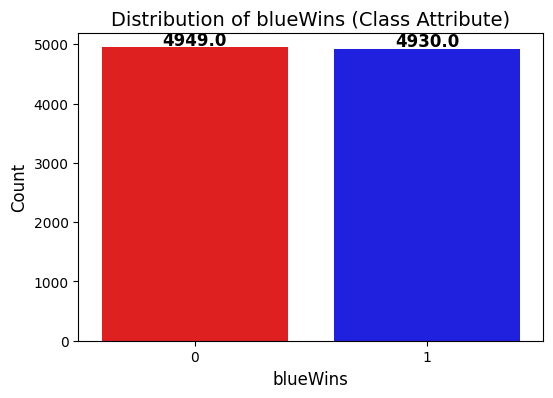

In [31]:
# Save the cleaned data
lolgame_data = data_clean

# Select numeric columns
lolgame_cols_num = lolgame_data.select_dtypes(include='number').columns.tolist()

# Visualize the distribution of the 'blueWins' attribute
plt.figure(figsize=(6, 4))
sns.countplot(x='blueWins', data=lolgame_data, hue='blueWins', palette=["red", "blue"], legend=False)

# Add count labels on top of the bars
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha = 'center', va = 'center', 
                fontsize=12, color='black', fontweight='bold', 
                xytext=(0, 5), textcoords='offset points')

# Set the title and labels
plt.title('Distribution of blueWins (Class Attribute)', fontsize=14)
plt.xlabel('blueWins', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Show the plot
plt.show()

As you can see, the blueWins target variable is practically balanced.

## Visual Analysis

First, let's take a look at the chance of winning the game by getting first blood ([**firstBlood**](##glossary)). First blood is an important metric to track, not only because of the morale boost it provides your team for getting the first kill, but it's also worth 33% more gold than a normal kill - it grants 400 gold instead of the normal 300 gold. To do this, we're going to calculate the conditional probability of winning given that the team got first blood. To calculate this, we'll calculate the number of times a team won the game and got first blood. We'll then divide that by the total number of times a team got first blood. This will give us the conditional probability we're looking for.

In [32]:
# Calculate the probabilities
blue_first_blood = lolgame_data['blueFirstBlood'] == 1
red_first_blood  = lolgame_data['blueFirstBlood'] == 0
blue_wins = lolgame_data['blueWins'] == 1
red_wins  = lolgame_data['blueWins'] == 0
prob_blueWins_blueFirstBlood = (blue_first_blood & blue_wins).sum() / blue_first_blood.sum()
prob_redWins_redFirstBlood = (red_first_blood & red_wins).sum() / red_first_blood.sum()

print(f"Probability blueWins when blueFirstBlood: {prob_blueWins_blueFirstBlood:.3f}")
print(f"Probability redWins when redFirstBlood  : {prob_redWins_redFirstBlood:.3f}")

Probability blueWins when blueFirstBlood: 0.599
Probability redWins when redFirstBlood  : 0.603


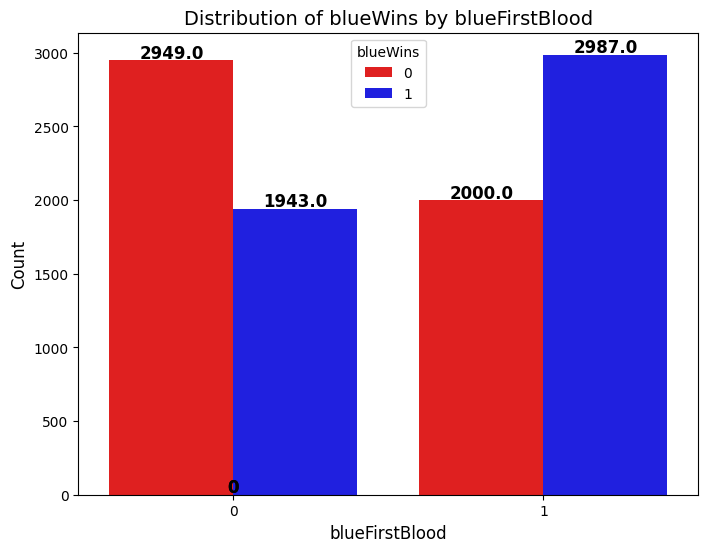

In [33]:

# Plot the stats
plt.figure(figsize=(8, 6))
sns.countplot(x='blueFirstBlood', hue='blueWins', data=lolgame_data, dodge=True, palette=["red", "blue"])

# Add count labels on top of the bars
ax = plt.gca()
for p in ax.patches:
    ax.annotate(f'{p.get_height()}',
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center',
                fontsize=12, color='black', fontweight='bold',
                xytext=(0, 5), textcoords='offset points')

# Set the title and labels
plt.title('Distribution of blueWins by blueFirstBlood', fontsize=14)
plt.xlabel('blueFirstBlood', fontsize=12)
plt.ylabel('Count', fontsize=12)

# Show the plot
plt.show()


As you can see, we can see that the team that gets the first blood (firstBlood) within the first 10 minutes is the favorite to win with approximately 60% probability (blue = 59.8957289 and red = 60.2820932). We can define this as:

$$
P(win|\text{firstBlood})=.60
$$

A 60% chance of winning is pretty high and doesn't seem like it's just a matter of chance. However, it's important to remember that a team isn't guaranteed to get first blood within the first 10 minutes. Therefore, we need to keep looking at other characteristics as well.

Now, let's see what effect dragon kills have on a team's victory.

In [34]:
lolgame_data['blueDragons'].unique()

array([0, 1])

In [35]:
# Calculate the probabilities
prob_blueWins_dragonsKilled = ((lolgame_data['blueDragons'] > 0) & blue_wins).sum() / (lolgame_data['blueDragons'] > 0).sum()
prob_blueNotWins_dragonsNotKilled = ((lolgame_data['blueDragons'] == 0) & red_wins).sum() / (lolgame_data['blueDragons'] == 0).sum()
prob_redWins_dragonsKilled = ((lolgame_data['redDragons'] > 0) & red_wins).sum() / (lolgame_data['redDragons'] > 0).sum()
prob_redNotWins_dragonsNotKilled = ((lolgame_data['redDragons'] == 0) & blue_wins).sum() / (lolgame_data['redDragons'] == 0).sum()

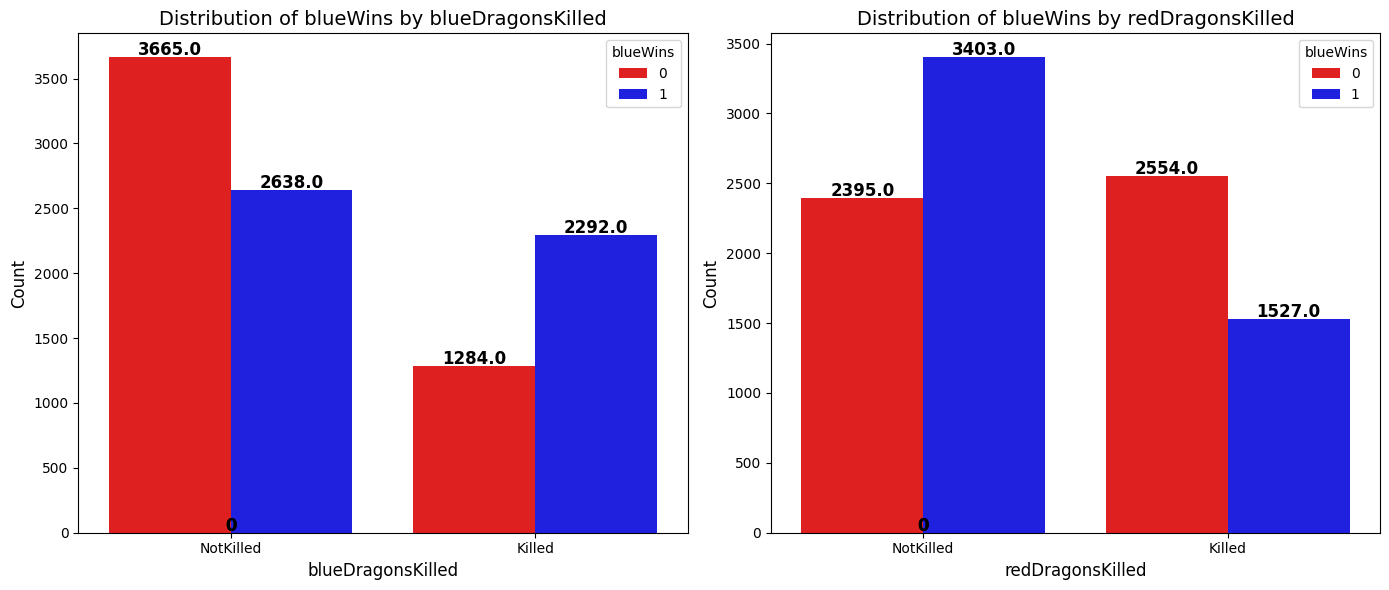

In [36]:
# Create subplots: 1 row, 2 columns
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for blueDragons
lolgame_data['blueDragonsKilled'] = lolgame_data['blueDragons'].apply(lambda x: 'Killed' if x > 0 else 'NotKilled')
sns.countplot(x='blueDragonsKilled', hue='blueWins', data=lolgame_data, dodge=True, palette=["red", "blue"], ax=axes[0])
# Add count labels on top of the bars
ax1 = axes[0]
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center',
                 fontsize=12, color='black', fontweight='bold',
                 xytext=(0, 5), textcoords='offset points')
ax1.set_title('Distribution of blueWins by blueDragonsKilled', fontsize=14)
ax1.set_xlabel('blueDragonsKilled', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)

# Plot for redDragons
lolgame_data['redDragonsKilled'] = lolgame_data['redDragons'].apply(lambda x: 'Killed' if x > 0 else 'NotKilled')
sns.countplot(x='redDragonsKilled', hue='blueWins', data=lolgame_data, dodge=True, palette=["red", "blue"], ax=axes[1])
# Add count labels on top of the bars
ax2 = axes[1]
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center',
                 fontsize=12, color='black', fontweight='bold',
                 xytext=(0, 5), textcoords='offset points')
ax2.set_title('Distribution of blueWins by redDragonsKilled', fontsize=14)
ax2.set_xlabel('redDragonsKilled', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)

# Adjust the legend to the right of the plots
#handles, labels = ax1.get_legend_handles_labels()
#fig.legend(handles, labels, title='blueWins', loc='center left', bbox_to_anchor=(1, 0.5), shadow=True, ncol=1)

# Adjust the layout to avoid overlap of labels
plt.tight_layout()

plt.show()

In [37]:
lolgame_data.drop(['blueDragonsKilled', 'redDragonsKilled'], axis=1, inplace=True)

In [38]:
print(f"Prob. Blue wins when dragonsKilled    : {prob_blueWins_dragonsKilled:.3f}")
print(f"Prob. Blue loses when dragonsNotKilled: {prob_blueNotWins_dragonsNotKilled:.3f}")
print(f"Prob. Red wins when dragonsKilled     : {prob_redWins_dragonsKilled:.3f}")
print(f"Prob. Red loses when dragonsNotKilled : {prob_redNotWins_dragonsNotKilled:.3f}")
print(f"Prob. Blue and Red win when dragonsKilled   : {(prob_blueWins_dragonsKilled + prob_redWins_dragonsKilled)/2:.3f}")
print(f"Prob. Blue and Red lose when dragonsNotKilled: {(prob_blueNotWins_dragonsNotKilled + prob_redNotWins_dragonsNotKilled)/2:.3f}")

Prob. Blue wins when dragonsKilled    : 0.641
Prob. Blue loses when dragonsNotKilled: 0.581
Prob. Red wins when dragonsKilled     : 0.626
Prob. Red loses when dragonsNotKilled : 0.587
Prob. Blue and Red win when dragonsKilled   : 0.633
Prob. Blue and Red lose when dragonsNotKilled: 0.584


As you can see a team that kills at least one dragon is more likely to win the game, with a 0.633% chance on average for both teams (blue=0.641% and red=0.626%). Looking inversely, a team that doesn't kill a dragon is also more likely to lose the game with a 0.584% chance on average for both teams (blue=0.581% and red=0.587%). This makes sense because of the impacts a single dragon can have throughout the game. Dragon is a neutral objective that provides powerful buffs ([bluffs](#glossary)) that scale based on the number of dragons you can kill. Because of these powerful, permanent, and potentially game-changing effects, getting a dragon greatly increases your chances of winning. We can see that this is an influential statistic for predicting winning a game. So, you can say that the probability of winning the game if you kill at least one dragon on average for both teams is:

$$
P(Win|\text{kill at least one dragon})=.633.
$$

Now, let's look at what effect herald kills have on a team's victory. With this information, we can determine whether a dragon or a herald is more important by looking at the probability of winning given a herald. By comparing our results to the results obtained for the probability of winning with at least one dragon, we should be able to understand which epic monster is more influential.

In [39]:
# Statistics
prob_blueWins_heraldKilled = (len(lolgame_data[(lolgame_data['blueHeralds'] > 0) & (lolgame_data['blueWins'] == 1)]) /
                                   len(lolgame_data[lolgame_data['blueHeralds'] > 0]))

prob_blueNotWins_heraldNotKilled = (len(lolgame_data[(lolgame_data['blueHeralds'] == 0) & (lolgame_data['blueWins'] == 0)]) /
                                         len(lolgame_data[lolgame_data['blueHeralds'] == 0]))

prob_redWins_heraldKilled = (len(lolgame_data[(lolgame_data['redHeralds'] > 0) & (lolgame_data['blueWins'] == 0)]) /
                                  len(lolgame_data[lolgame_data['redHeralds'] > 0]))

prob_redNotWins_heraldNotKilled = (len(lolgame_data[(lolgame_data['redHeralds'] == 0) & (lolgame_data['blueWins'] == 1)]) /
                                        len(lolgame_data[lolgame_data['redHeralds'] == 0]))

# Convert columns to categorical variables for visualization
lolgame_data['blueHeraldsKilled'] = np.where(lolgame_data['blueHeralds'] > 0, 'Killed', 'NotKilled')
lolgame_data['redHeraldsKilled'] = np.where(lolgame_data['redHeralds'] > 0, 'Killed', 'NotKilled')

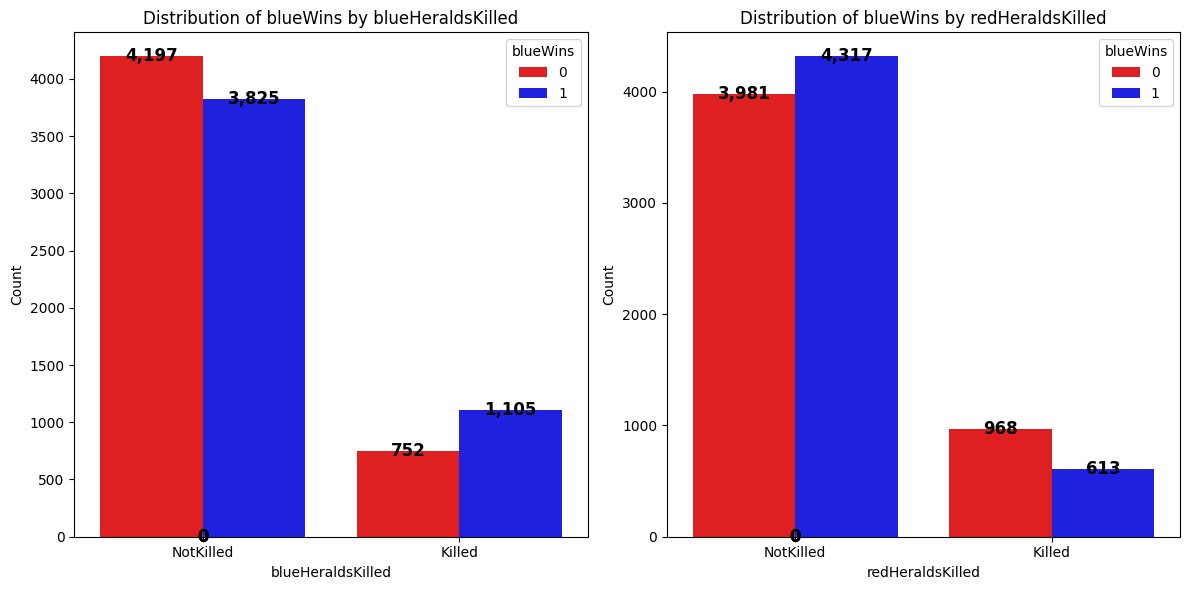

In [40]:
# Create the plots
plt.figure(figsize=(12, 6))

# Plot for blueHeralds
plt.subplot(1, 2, 1)
sns.countplot(data=lolgame_data, x='blueHeraldsKilled', hue='blueWins', dodge=True,
              palette=['red', 'blue'])
plt.title('Distribution of blueWins by blueHeraldsKilled')
plt.xlabel('blueHeraldsKilled')
plt.ylabel('Count')

# Add labels to the bars
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=12, color='black', fontweight='bold')

# Plot for redHeralds
plt.subplot(1, 2, 2)
sns.countplot(data=lolgame_data, x='redHeraldsKilled', hue='blueWins', dodge=True,
              palette=['red', 'blue'])
plt.title('Distribution of blueWins by redHeraldsKilled')
plt.xlabel('redHeraldsKilled')
plt.ylabel('Count')

# Add labels to the bars
for p in plt.gca().patches:
    plt.gca().annotate(f'{p.get_height():,.0f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=12, color='black', fontweight='bold')

# Display the legend at the top
#plt.legend(title='blueWins', loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)

plt.tight_layout()
plt.show()

In [41]:
lolgame_data.drop(['blueHeraldsKilled', 'redHeraldsKilled'], axis=1, inplace=True)

In [42]:
print(f"Prob. Blue wins when heraldKilled    : {prob_blueWins_heraldKilled:.3f}")
print(f"Prob. Blue loses when heraldNotKilled: {prob_blueNotWins_heraldNotKilled:.3f}")
print(f"Prob. Red wins when heraldKilled     : {prob_redWins_heraldKilled:.3f}")
print(f"Prob. Red loses when heraldNotKilled : {prob_redNotWins_heraldNotKilled:.3f}")
print(f"Prob. Blue and Red win when heraldKilled    : {(prob_blueWins_heraldKilled + prob_redWins_heraldKilled) /2:.3f}")
print(f"Prob. Blue and Red lose when heraldNotKilled: {(prob_blueNotWins_heraldNotKilled + prob_redNotWins_heraldNotKilled) /2:.3f}")

Prob. Blue wins when heraldKilled    : 0.595
Prob. Blue loses when heraldNotKilled: 0.523
Prob. Red wins when heraldKilled     : 0.612
Prob. Red loses when heraldNotKilled : 0.520
Prob. Blue and Red win when heraldKilled    : 0.604
Prob. Blue and Red lose when heraldNotKilled: 0.522


As you can see, a team that kills at least one herald is more likely to win the game, with a 0.604% probability on average for both teams (blue=0.595% and red=0.612%). If we look at the reverse, a team that does not kill a herald is also more likely to lose the game, with a 0.522% probability on average for both teams (blue=0.523% and red=0.520%).

The **herald** is a neutral target that, once defeated, will fight for our army and destroy turrets extremely quickly. Given the number of gold turret kills awarded in addition to the additional territory gained from the turret kill, securing the herald is important in determining which team will win the game.

However, comparing it with the results we got for dragons, we can conclude that it is not as influential in the game as

$$
P(Win|\text{kill at least one herald})=.604 < P(Win|\text{kill at least one dragon}) =.633. 
$$

This makes sense because the dragon gives you boosted stats that will last the entire game, while the herald will only affect the game for a few minutes unless killed before then. Additionally, the amount of wins obtained is higher with the dragon metric than with the herald.



Let's continue with the probability of winning if at least one tower has been destroyed.

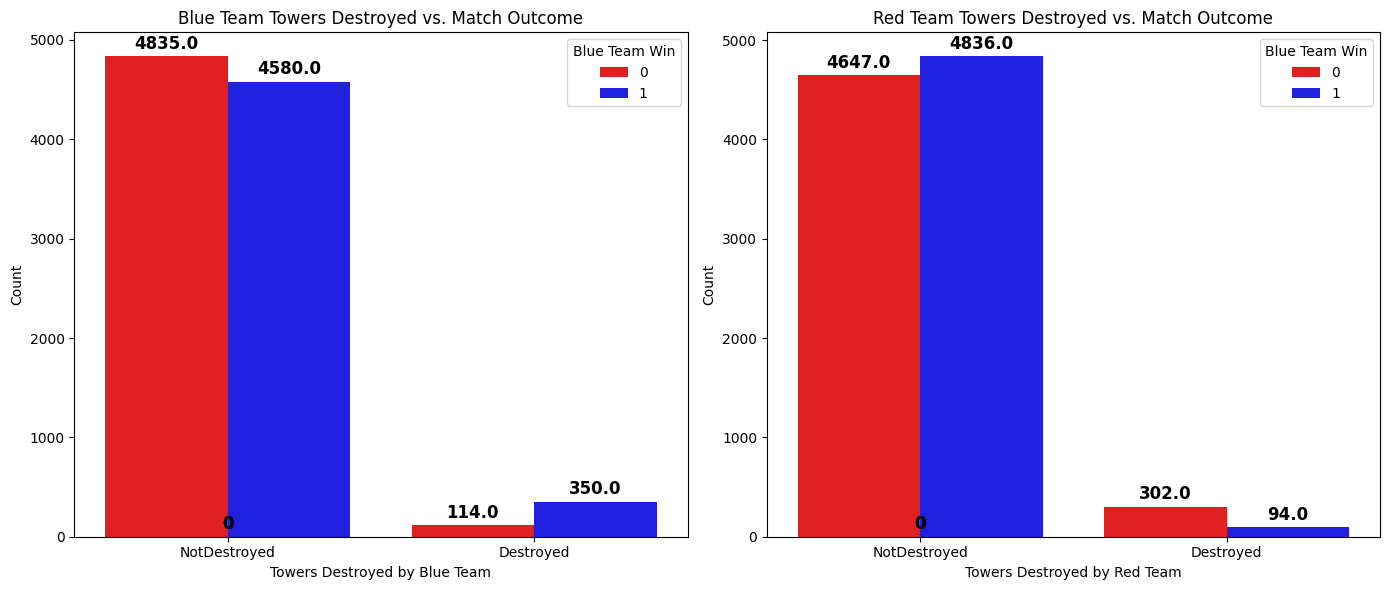

In [43]:
# Blue Team Towers Destroyed vs Match Outcome
lolgame_data['blueTowersDestroyedStatus'] = lolgame_data['blueTowersDestroyed'].apply(lambda x: 'Destroyed' if x > 0 else 'NotDestroyed')

# Set up a figure with two subplots (side by side)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot 1: Blue Team Towers Destroyed vs Match Outcome
sns.countplot(data=lolgame_data, x='blueTowersDestroyedStatus', hue='blueWins', dodge=True, palette=['red', 'blue'], ax=ax1)
for p in ax1.patches:
    ax1.annotate(f'{p.get_height()}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', 
                 fontweight='bold', xytext=(0, 9), textcoords='offset points')

ax1.set_title('Blue Team Towers Destroyed vs. Match Outcome')
ax1.set_xlabel('Towers Destroyed by Blue Team')
ax1.set_ylabel('Count')
ax1.legend(title='Blue Team Win', loc='upper right')

# Red Team Towers Destroyed vs Match Outcome
lolgame_data['redTowersDestroyedStatus'] = lolgame_data['redTowersDestroyed'].apply(lambda x: 'Destroyed' if x > 0 else 'NotDestroyed')

# Plot 2: Red Team Towers Destroyed vs Match Outcome
sns.countplot(data=lolgame_data, x='redTowersDestroyedStatus', hue='blueWins', dodge=True, palette=['red', 'blue'], ax=ax2)
for p in ax2.patches:
    ax2.annotate(f'{p.get_height()}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', fontsize=12, color='black', 
                 fontweight='bold', xytext=(0, 9), textcoords='offset points')

ax2.set_title('Red Team Towers Destroyed vs. Match Outcome')
ax2.set_xlabel('Towers Destroyed by Red Team')
ax2.set_ylabel('Count')
ax2.legend(title='Blue Team Win', loc='upper right')

# Adjust layout to make room for the titles and labels
plt.tight_layout()

# Show the plots
plt.show()

In [44]:
lolgame_data.drop(['blueTowersDestroyedStatus', 'redTowersDestroyedStatus'], axis=1, inplace=True)

In [45]:
# Blue team towers destroyed and blue team win
blue_wins_towers_destroyed = len(lolgame_data[(lolgame_data['blueTowersDestroyed'] > 0) & (lolgame_data['blueWins'] == 1)]) / len(lolgame_data[lolgame_data['blueTowersDestroyed'] > 0])

# Blue team towers not destroyed and blue team loss
blue_not_wins_towers_not_destroyed = len(lolgame_data[(lolgame_data['blueTowersDestroyed'] == 0) & (lolgame_data['blueWins'] == 0)]) / len(lolgame_data[lolgame_data['blueTowersDestroyed'] == 0])

# Red team towers destroyed and red team loss
red_wins_towers_destroyed = len(lolgame_data[(lolgame_data['redTowersDestroyed'] > 0) & (lolgame_data['blueWins'] == 0)]) / len(lolgame_data[lolgame_data['redTowersDestroyed'] > 0])

# Red team towers not destroyed and red team win
red_not_wins_towers_not_destroyed = len(lolgame_data[(lolgame_data['redTowersDestroyed'] == 0) & (lolgame_data['blueWins'] == 1)]) / len(lolgame_data[lolgame_data['redTowersDestroyed'] == 0])

# Print calculated probabilities (optional)
print(f"Blue wins with towers destroyed     : {blue_wins_towers_destroyed:.3f}")
print(f"Blue loses with towers not destroyed: {blue_not_wins_towers_not_destroyed:.3f}")
print(f"Red wins with towers destroyed      : {red_wins_towers_destroyed:.3f}")
print(f"Red loses with towers not destroyed : {red_not_wins_towers_not_destroyed:.3f}")


Blue wins with towers destroyed     : 0.754
Blue loses with towers not destroyed: 0.514
Red wins with towers destroyed      : 0.763
Red loses with towers not destroyed : 0.510


It seems that destroying a tower in the first 10 minutes significantly increases your chances of winning more than securing a **Dragon**, **Herald**, or **First Blood**. Intuitively, this makes sense because it is much harder to destroy a tower than it is to get first blood or kill an epic monster. Also, with the context of League of Legends' economy it makes sense that granting global gold in addition to map advantage leads to a win.



Next, let's look at some of the other features to see if we can find a correlation between them. For these features, we will no longer look at the conditional probability, we will look at the histograms. If the data is unimodal, that would show us that the feature does not significantly affect either team's win rate. If the data is bimodal, that means there is a difference between when the blue team typically wins and when the red team typically wins for that feature. This would tell us that the feature is significant.

To start, we'll look at a histogram of the *gold difference*. *Just a note that the gold differences are relative to the blue team*. This means that *positive gold differences mean that blue is ahead in gold*, and *negative gold differences mean that red is ahead*.

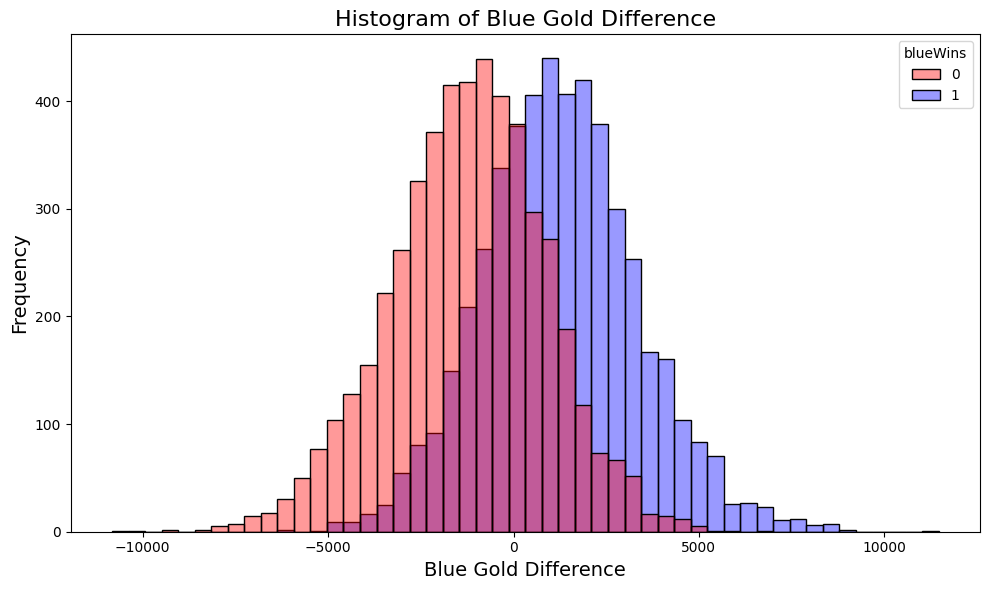

In [46]:
plt.figure(figsize=(10, 6))

# Create a histogram of blueGoldDiff, with color based on blueWins
sns.histplot(data=lolgame_data, x='blueGoldDiff', hue='blueWins', 
             kde=False, bins=50, alpha=0.4, palette=['red', 'blue'])

# Title and labels
plt.title('Histogram of Blue Gold Difference', fontsize=16)
plt.xlabel('Blue Gold Difference', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

The red section represents the times the red team won and the blue section represents the times the blue team won, and the purple section represents the times both teams won before.

It is clear that once the gold advantage for a team reaches around 5000 (or -5000), the game is almost won for a team. This data is bimodal and that is expected for the gold difference. The more gold advantage blue has, the more likely it is to win. The same goes for red. Therefore, the gold advantage has a significant impact. Of course, there are times when teams win even when they are way below gold, but they are few and far between (and usually due to human error).

Next, we inspect the experience difference.

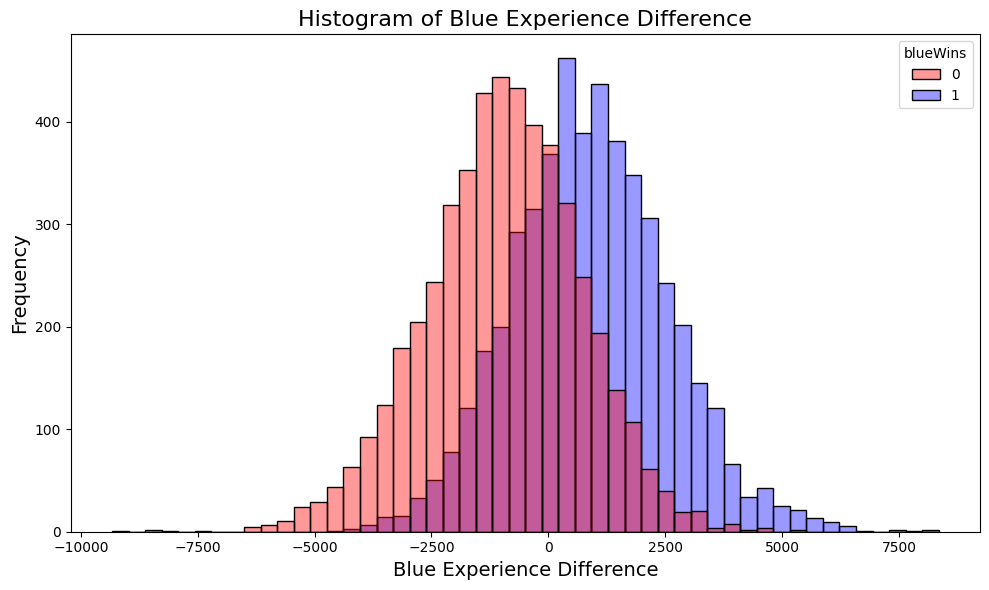

In [47]:
plt.figure(figsize=(10, 6))

# Create a histogram for blueExperienceDiff, with color based on blueWins
sns.histplot(data=lolgame_data, x='blueExperienceDiff', hue='blueWins', 
             kde=False, bins=50, alpha=0.4, palette=['red', 'blue'])

# Title and labels
plt.title('Histogram of Blue Experience Difference', fontsize=16)
plt.xlabel('Blue Experience Difference', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

It is clear that having an experience leader will result in having a leader for your team as the data is bimodal. For both the blue and red team, there is a tendency to win if you have the experience advantage, and the chance of winning increases as you gain an increasing experience advantage. With around 3750 (or -3750) experience points advantage for a team, you can expect to win the game. Similarly, experience is a major factor in determining whether you will win a League match.

Now, let's look at the KDA difference.

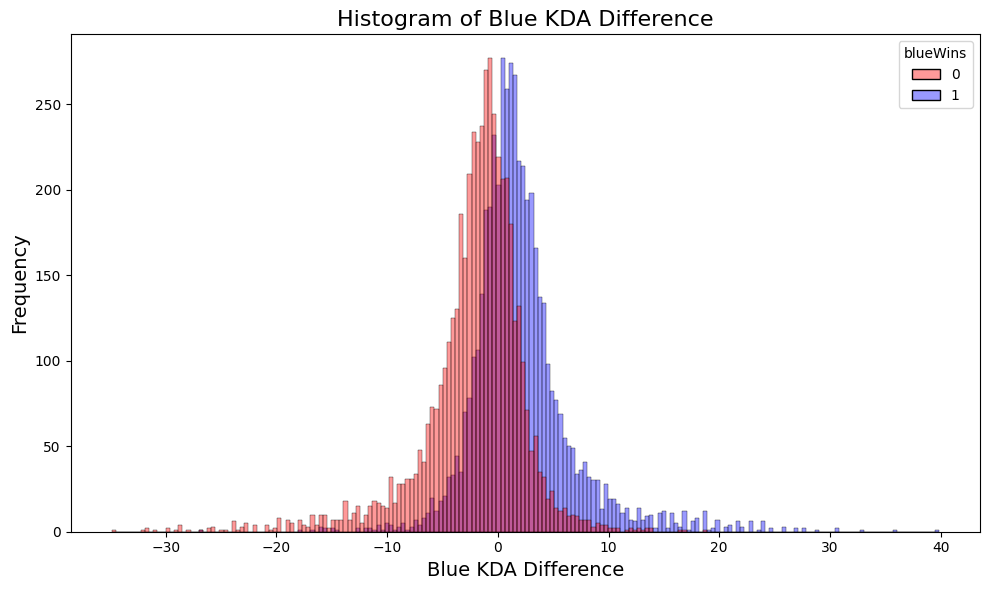

In [48]:
plt.figure(figsize=(10, 6))

# Create a histogram for blueKDADiff, with color based on blueWins
sns.histplot(data=lolgame_data, x='blueKDADiff', hue='blueWins', 
             kde=False, bins=200, alpha=0.4, palette=['red', 'blue'])

# Title and labels
plt.title('Histogram of Blue KDA Difference', fontsize=16)
plt.xlabel('Blue KDA Difference', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

This data is barely bimodal (it looks basically unimodal), indicating that KDA is less important than other factors. While it is clear from the graph that having a KDA advantage over your opponent will result in wins, the boundary is not as clear as it is with the other metrics mentioned above. It is noticeable that with a difference of slightly more than 10 KDA for a team, you can expect to win. That being said, KDA is a factor in determining whether you will win the game.

Next, we will look at CS, which is the number of monsters killed.

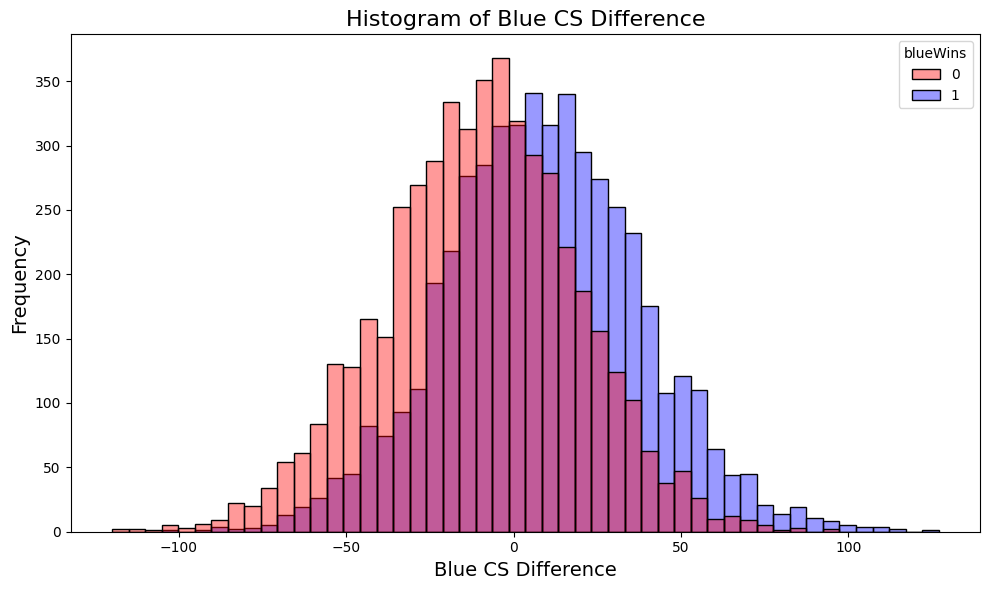

In [49]:
plt.figure(figsize=(10, 6))

# Create a histogram for blueCSDiff, with color based on blueWins
sns.histplot(data=lolgame_data, x='blueCSDiff', hue='blueWins', 
             kde=False, bins=50, alpha=0.4, palette=['red', 'blue'])

# Title and labels
plt.title('Histogram of Blue CS Difference', fontsize=16)
plt.xlabel('Blue CS Difference', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

This data seems barely bimodal, indicating that there is a marginal importance to CS in a win. Although a CS lead is not a trivial factor due to the amount of gold CS provides, it is clear that surprises can happen despite a CS lead. A CS lead of around 80 will guarantee your team a win, but just like with KDA, there is a chance that a slight lead won’t really have an impact on winning the game. There is a lot of overlap in the middle, meaning that unless you have a considerable lead, the stat is not the most accurate for predicting who will win.

The next stat we will look at is Jungle CS, which is the number of jungle monsters killed.

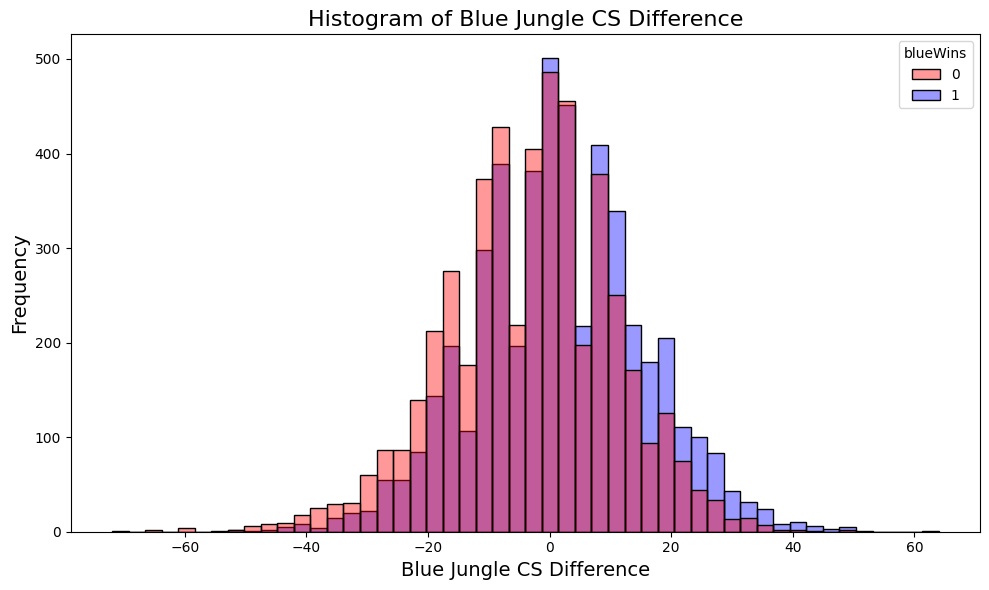

In [50]:
plt.figure(figsize=(10, 6))

# Create a histogram for blueJGCSDiff, with color based on blueWins
sns.histplot(data=lolgame_data, x='blueJGCSDiff', hue='blueWins', 
             kde=False, bins=50, alpha=0.4, palette=['red', 'blue'])

# Title and labels
plt.title('Histogram of Blue Jungle CS Difference', fontsize=16)
plt.xlabel('Blue Jungle CS Difference', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

The graph above appears unimodal, indicating a negligible impact on whether or not a team will win a game. **Jungle CS** appears to have even less of an impact than regular CS. There is a large amount of purple cross section, meaning that there were many cases where, despite a jungle CS advantage, the team at a disadvantage in this metric won anyway. Because of this uncertainty and the unimodal nature of the graph, we are better off removing this variable as we do not want to add unnecessary complexity to it.

The next feature we will look at is **wards**.

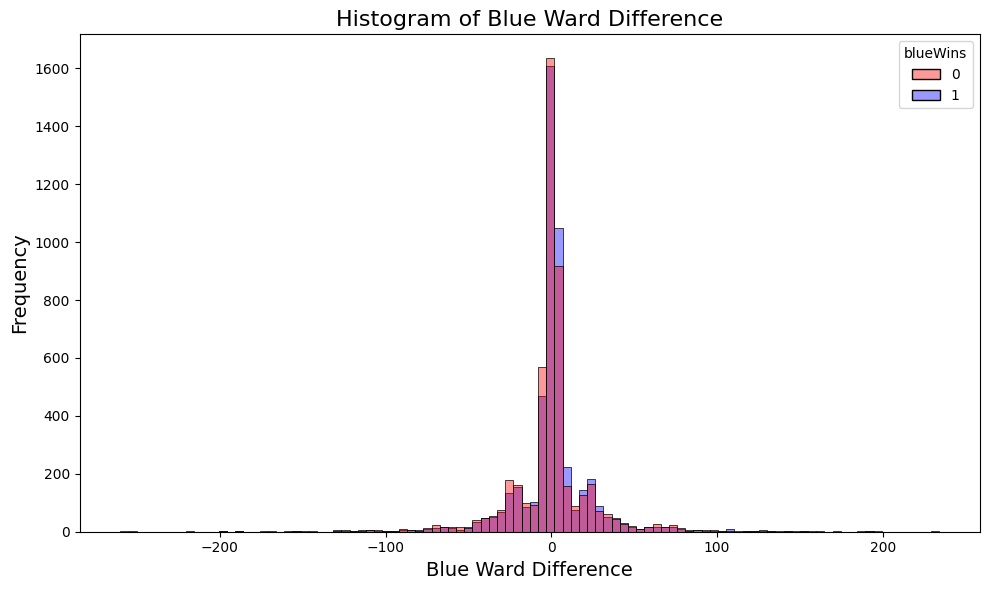

In [51]:
plt.figure(figsize=(10, 6))

# Create a histogram for blueWardDiff, with color based on blueWins
sns.histplot(data=lolgame_data, x='blueWardDiff', hue='blueWins', 
             kde=False, bins=100, alpha=0.4, palette=['red', 'blue'])

# Title and labels
plt.title('Histogram of Blue Ward Difference', fontsize=16)
plt.xlabel('Blue Ward Difference', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

This data is very unimodal. The difference in wards appears to be completely insignificant and is therefore a candidate for removal. The large amount of majority purple area means that while having a vision advantage in the wards may seem important, it is not very accurate in determining who will win a league game, with no real value in guaranteeing a game win.

Finally, let's inspect the last feature, the difference in wards destroyed.

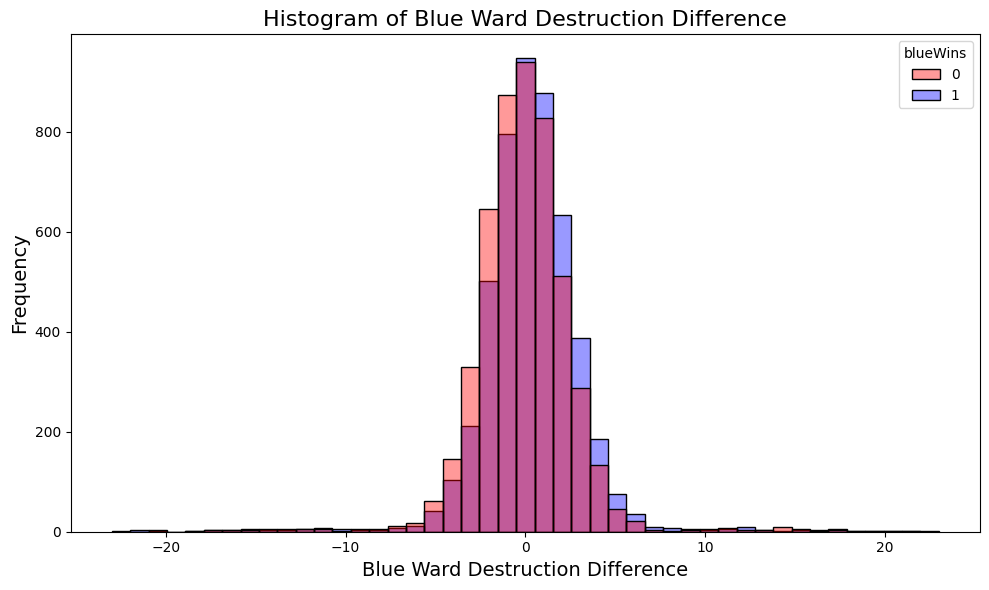

In [52]:
plt.figure(figsize=(10, 6))

# Create a histogram for blueDestWardDiff, with color based on blueWins
sns.histplot(data=lolgame_data, x='blueDestWardDiff', hue='blueWins', 
             kde=False, bins=45, alpha=0.4, palette=['red', 'blue'])

# Title and labels
plt.title('Histogram of Blue Ward Destruction Difference', fontsize=16)
plt.xlabel('Blue Ward Destruction Difference', fontsize=14)
plt.ylabel('Frequency', fontsize=14)

# Show the plot
plt.tight_layout()
plt.show()

Again, since the graph is very unimodal, let's get rid of it. With a distribution like this, all it would do is add unnecessary complexity. Therefore, this variable is a candidate for removal.

From the above analysis, it can be seen that there are three variables that can be removed because they would add complexity to the model: `blueJGCSDiff`, `blueWardDiff` and `blueDestWardDiff`.

## Identification of correlated predictors

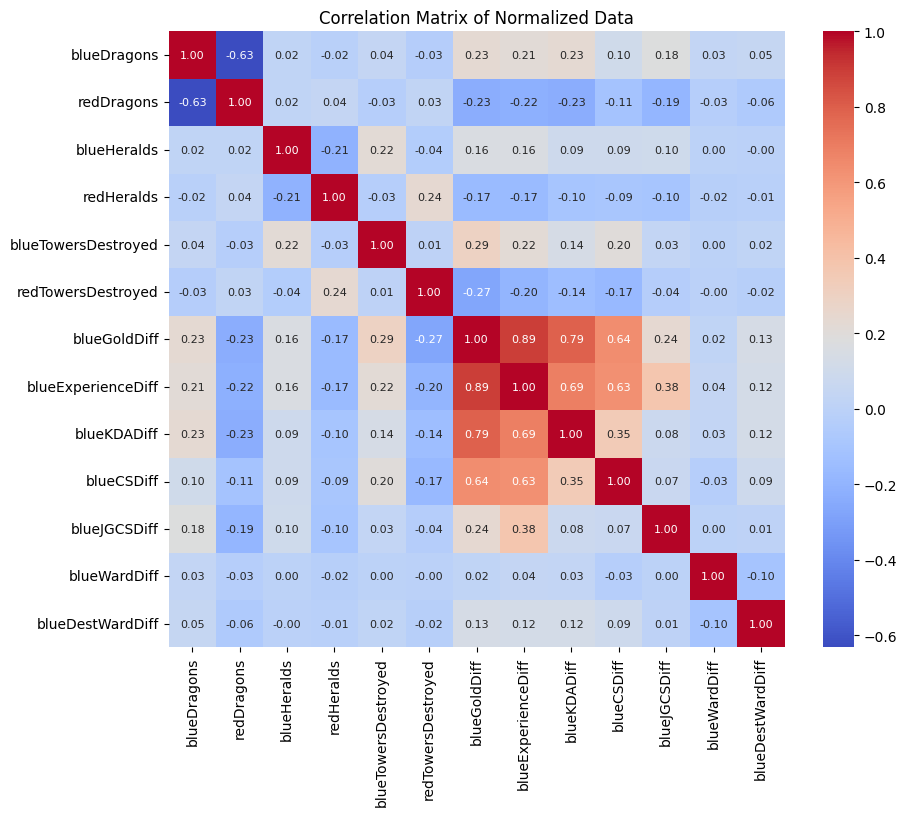

In [53]:
# Select only numeric columns
#lolgame_data_numeric = lolgame_data.select_dtypes(include=[np.number])
lolgame_data_numeric = lolgame_data[lolgame_numeric_cols]

# Normalize the data (center and scale)
scaler = StandardScaler()
lolgame_data_norm = scaler.fit_transform(lolgame_data_numeric)

# Convert back to DataFrame for ease of use
lolgame_data_norm = pd.DataFrame(lolgame_data_norm, columns=lolgame_data_numeric.columns)

# Calculate Pearson correlation
corr_matrix = lolgame_data_norm.corr(method='pearson')

# Plot correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', 
            square=True, cbar=True, annot_kws={"size": 8},
            xticklabels=corr_matrix.columns, 
            yticklabels=corr_matrix.columns)
plt.title('Correlation Matrix of Normalized Data')
plt.show()

In [54]:
# Crear una máscara que excluye la diagonal (correlación consigo misma)
mask = np.triu(np.ones_like(corr_matrix, dtype=bool), k=1)

# Filtrar las correlaciones que superan el umbral
correlation_pairs = corr_matrix.where(mask).stack().sort_values(ascending=False).reset_index()
correlation_pairs.columns = ['feature1', 'feature2', 'corr']

# Umbral de correlación (por ejemplo, 0.8)
threshold = 0.62
# Filtrar por correlaciones mayores que el umbral
high_corr_pairs = correlation_pairs[correlation_pairs['corr'].abs() > threshold]
high_corr_pairs

,feature1,feature2,corr
0,blueGoldDiff,blueExperienceDiff,0.894729
1,blueGoldDiff,blueKDADiff,0.794174
2,blueExperienceDiff,blueKDADiff,0.693561
3,blueGoldDiff,blueCSDiff,0.638765
4,blueExperienceDiff,blueCSDiff,0.625556
77,blueDragons,redDragons,-0.631930


In [55]:
correlation_pairs.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
corr,78.0,0.061533,0.236408,-0.63193,-0.036578,0.02327,0.135485,0.894729


At a glance, you can see that the following pairs of variables have significant correlations:

- `blueGoldDiff` and `blueExperienceDiff` have a positive correlation (0.894729)

- `blueKDADiff` and `blueGoldDiff` have a positive correlation (0.794174).

- `blueGoldDiff` and `blueCSDiff` have a positive correlation (0.693561)

- `blueDragons` and `redDragons` have a negative correlation (-0.631930)

- `blueExperienceDiff` and `blueCSDiff` have a negative correlation (0.625556)

Let's see what the maximum correlation of the variables is

We are going to look for the variables that have correlation coefficients greater than 75%.

In [56]:
# Umbral de correlación (por ejemplo, 0.8)
threshold = 0.75

# Filtrar por correlaciones mayores que el umbral
high_corr_pairs = correlation_pairs[correlation_pairs['corr'].abs() > threshold]
high_corr_pairs

,feature1,feature2,corr
0,blueGoldDiff,blueExperienceDiff,0.894729
1,blueGoldDiff,blueKDADiff,0.794174


In [57]:
# Removemos atributos de alta correlacion
lolgame_data_norm_rmhc = lolgame_data_norm.drop(['blueGoldDiff'], axis=1)

# Calculate Pearson correlation
corr_matrix_rmhc = lolgame_data_norm_rmhc.corr(method='pearson')

# Crear una máscara que excluye la diagonal (correlación consigo misma)
mask = np.triu(np.ones_like(corr_matrix_rmhc, dtype=bool), k=1)

# Filtrar las correlaciones que superan el umbral
correlation_pairs = corr_matrix_rmhc.where(mask).stack().sort_values(ascending=False).reset_index()
correlation_pairs.columns = ['feature1', 'feature2', 'corr']

correlation_pairs.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
corr,66.0,0.031197,0.187912,-0.63193,-0.036578,0.016059,0.096353,0.693561


It can be observed that our correlation has decreased by removing the blueGoldDiff variable.

# Data Partition

In [58]:
# Separar las características y la variable objetivo
#X = lolgame_data[categorical_features + numerical_features]
#y = lolgame_data[target]
seed = 42
# Codificar las características categóricas (Si ya están en 0 y 1, no hace falta hacerlo de nuevo)
# Si las características categóricas no están en 0/1, puedes usar pd.get_dummies() o LabelEncoder

# X['blueFirstBlood'] = X['blueFirstBlood'].astype('category')

# Dividir los datos en conjuntos de entrenamiento y prueba
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

df_full_train, df_test = train_test_split(lolgame_data, test_size=0.2, random_state=seed)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=seed)

In [59]:
# Reset index
df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

# Y
y_full_train = df_full_train[target].values
y_train = df_train[target].values
y_val = df_val[target].values
y_test = df_test[target].values

# Remove y
df_full_train = df_full_train.drop(columns=[target])
df_train = df_train.drop(columns=[target])
df_val = df_val.drop(columns=[target])
df_test = df_test.drop(columns=[target])

In [60]:
print(f"lolgame_data :{len(lolgame_data)}, train :{len(df_train)} ({len(df_train)/len(lolgame_data):.2f})%")
print(f"lolgame_data :{len(lolgame_data)}, val   :{len(df_val)} ({len(df_val)/len(lolgame_data):.2f})%")
print(f"lolgame_data :{len(lolgame_data)}, test  :{len(df_test)} ({len(df_test)/len(lolgame_data):.2f})%")

lolgame_data :9879, train :5927 (0.60)%
lolgame_data :9879, val   :1976 (0.20)%
lolgame_data :9879, test  :1976 (0.20)%


# Feature importante

https://machinelearningmastery.com/rfe-feature-selection-in-python/


https://medium.com/@mukherjee.abhradeep/feature-selection-and-feature-importance-section-1-a9b460eeb997

## Random Forest

To find the importance of the features, three models are used: Random Forest, XGBoost and Extra Trees.

In [61]:
def feature_importance_rf(
    X_train, y_train, X_test, y_test,
    numerical_features, categorical_features
):
    # 1. **Randsom Forest**
    scaler = StandardScaler()
    
    # Preproessing
    categorical_encoder = OrdinalEncoder(
        handle_unknown="use_encoded_value", unknown_value=-1, encoded_missing_value=-1
    )
    preprocessor = ColumnTransformer(transformers=[
        ('num', scaler, numerical_features),
        ("cat", categorical_encoder, categorical_features),
    ])
    
    # Train a Random Forest model
    # min_samples_leaf=5 or min_samples_leaf=10
    classifier = RandomForestClassifier(n_estimators=100, min_samples_leaf=5, random_state=42)
    model = Pipeline(
        [
            ("preprocess", preprocessor),
            ("classifier", classifier)
        ]
    )
    model.fit(X_train, y_train)
    
    print(f"RF train accuracy: {model.score(X_train, y_train):.3f}")
    print(f"RF test accuracy: {model.score(X_test, y_test):.3f}")
    
    # Getting the importance of the features
    feature_names = model[:-1].get_feature_names_out()
    importances = model[-1].feature_importances_
    
    # Crear un DataFrame con la importancia de las características
    importance_df = pd.Series(
        importances, index=feature_names
    ).sort_values(ascending=False)

    return importance_df

In [62]:
rf_importance_df = feature_importance_rf(
    df_train, y_train, 
    df_test, y_test, 
    NUMERICAL_FEATURES, CATEGORICAL_FEATURES
)

RF train accuracy: 0.861
RF test accuracy: 0.726


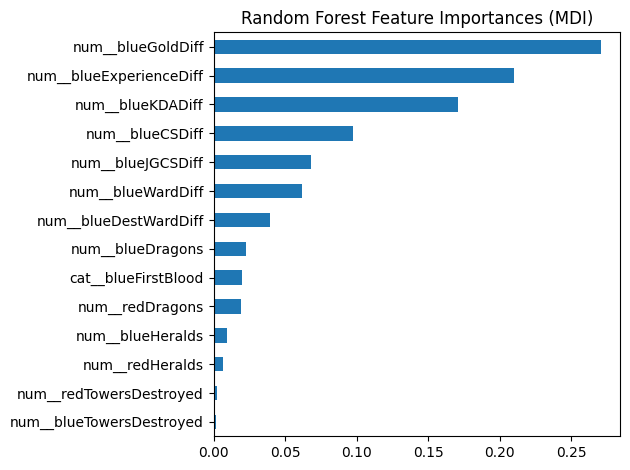

In [63]:
ax = rf_importance_df.sort_values(ascending=True).plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

## XGB

In [64]:
def feature_importance_xgb(
    X_train, y_train, X_test, y_test,
    numerical_features, categorical_features
):
    # Preproessing
    categorical_encoder = OrdinalEncoder(
        handle_unknown="use_encoded_value", unknown_value=-1, encoded_missing_value=-1
    )
    preprocessor = ColumnTransformer(transformers=[
        ('num', scaler, numerical_features),
        ("cat", categorical_encoder, categorical_features),
    ])
    
    # Train a Random Forest model
    # min_samples_leaf=5 or min_samples_leaf=10
    xgb_model = Pipeline(
        [
            ("preprocess", preprocessor),
            ("classifier", xgb.XGBClassifier())
        ]
    )
    xgb_model.fit(X_train, y_train)
    
    print(f"RF train accuracy: {xgb_model.score(X_train, y_train):.3f}")
    print(f"RF test accuracy: {xgb_model.score(X_test, y_test):.3f}")

    # Getting the importance of the features
    xgb_feature_names = xgb_model[:-1].get_feature_names_out()
    xgb_importances = xgb_model[-1].feature_importances_
    
    # Crear un DataFrame con la importancia de las características
    xgb_importance_df = pd.Series(
        xgb_importances, index=xgb_feature_names
    ).sort_values(ascending=False)

    return xgb_importance_df

In [65]:
xgb_importance_df = feature_importance_xgb(
    df_train, y_train, 
    df_test, y_test, 
    NUMERICAL_FEATURES, CATEGORICAL_FEATURES
)

RF train accuracy: 0.923
RF test accuracy: 0.704


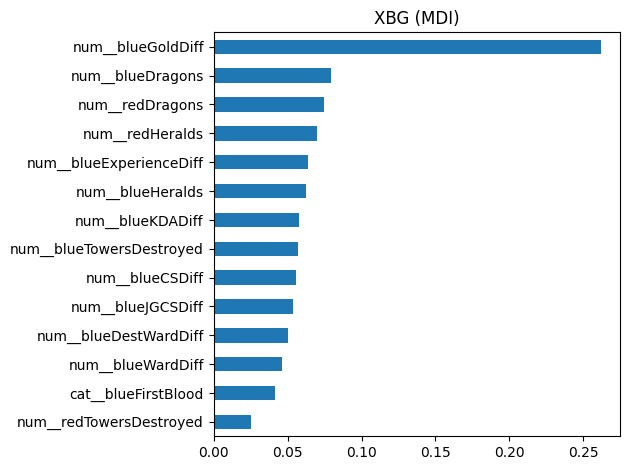

In [66]:
ax = xgb_importance_df.sort_values(ascending=True).plot.barh()
ax.set_title("XBG (MDI)")
ax.figure.tight_layout()

## ExtraTreesRegressor

In [67]:
def feature_importance_extr(
    X_train, y_train, X_test, y_test,
    numerical_features, categorical_features
):
    # Preproessing
    scaler = StandardScaler()
    categorical_encoder = OrdinalEncoder(
        handle_unknown="use_encoded_value", unknown_value=-1, encoded_missing_value=-1
    )
    preprocessor = ColumnTransformer(transformers=[
        ('num', scaler, numerical_features),
        ("cat", categorical_encoder, categorical_features),
    ])

    # Train a Random Forest model
    classifier = ExtraTreesClassifier(n_estimators = 100, criterion ='entropy', min_samples_leaf = 5, max_features = 5)
    model = Pipeline(
        [
            ("preprocess", preprocessor),
            ("classifier", classifier)
        ]
    )
    model.fit(X_train, y_train)
    
    print(f"ETR train accuracy: {model.score(X_train, y_train):.3f}")
    print(f"ETR test accuracy : {model.score(X_test, y_test):.3f}")

    # Getting the importance of the features
    feature_names = model[:-1].get_feature_names_out()
    importances = model[-1].feature_importances_
    
    # Crear un DataFrame con la importancia de las características
    importance_df = pd.Series(
        importances, index=feature_names
    ).sort_values(ascending=False)

    return importance_df

In [68]:
extr_importance_df = feature_importance_extr(
    df_train, y_train, 
    df_test, y_test, 
    NUMERICAL_FEATURES, CATEGORICAL_FEATURES
)

ETR train accuracy: 0.798
ETR test accuracy : 0.735


In [69]:
#etr_model[-1].estimators_
#std = np.std([tree.feature_importances_ for tree in etr_model[-1].estimators_], axis=0)

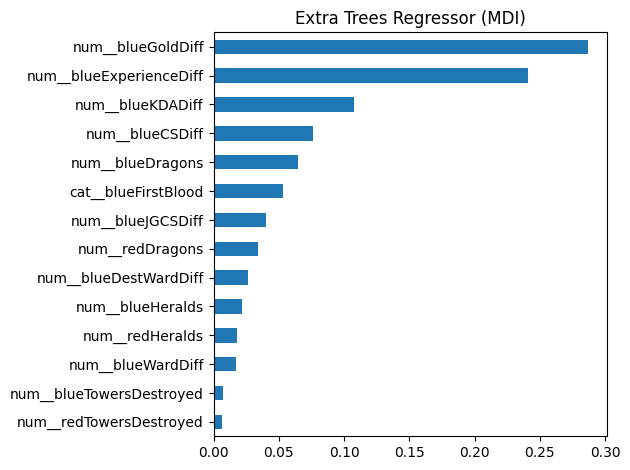

In [70]:
ax = extr_importance_df.sort_values(ascending=True).plot.barh()
ax.set_title("Extra Trees Regressor (MDI)")
ax.figure.tight_layout()

In [71]:
selected_cols_rf   = [tra_col.split('__')[1]  for tra_col in rf_importance_df[rf_importance_df > 0.03].index]
selected_cols_extr = [tra_col.split('__')[1]  for tra_col in extr_importance_df[extr_importance_df > 0.03].index]

In [72]:
set(selected_cols_rf).intersection(set(selected_cols_extr))

{'blueCSDiff',
 'blueExperienceDiff',
 'blueGoldDiff',
 'blueJGCSDiff',
 'blueKDADiff'}

In [73]:
selected_cols_rf

['blueGoldDiff',
 'blueExperienceDiff',
 'blueKDADiff',
 'blueCSDiff',
 'blueJGCSDiff',
 'blueWardDiff',
 'blueDestWardDiff']

In [74]:
selected_cols_extr

['blueGoldDiff',
 'blueExperienceDiff',
 'blueKDADiff',
 'blueCSDiff',
 'blueDragons',
 'blueFirstBlood',
 'blueJGCSDiff',
 'redDragons']

In [75]:
selected_numerical_features = list(set(NUMERICAL_FEATURES) - set(["blueJGCSDiff", "blueWardDiff", "blueDestWardDiff"]))
selected_numerical_features

['blueGoldDiff',
 'blueTowersDestroyed',
 'blueDragons',
 'blueHeralds',
 'blueCSDiff',
 'redTowersDestroyed',
 'redDragons',
 'blueKDADiff',
 'blueExperienceDiff',
 'redHeralds']

In [76]:
CATEGORICAL_FEATURES_FS = [col for col in selected_cols_extr if col in NUMERICAL_FEATURES]
NUMERICAL_FEATURES_FS = [col for col in selected_cols_extr if col not in NUMERICAL_FEATURES]

In [77]:
CATEGORICAL_FEATURES_FS, NUMERICAL_FEATURES_FS

(['blueGoldDiff',
  'blueExperienceDiff',
  'blueKDADiff',
  'blueCSDiff',
  'blueDragons',
  'blueJGCSDiff',
  'redDragons'],
 ['blueFirstBlood'])

# Training

In [78]:
def calculate_precision_recall_f1(y_val, y_pred):
    scores = []

    thresholds = np.linspace(0, 1, 101)

    for t in thresholds:
        '''
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)

        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)

        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()

        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()

        precision = tp / (tp + fp) if tp + fp > 0 else 0
        recall = tp / (tp + fn) if tp + fn > 0 else 0

        f1_score = 2 * (precision * recall) / (precision + recall) if precision + recall > 0 else 0
        '''
        recall = recall_score(y_val, y_pred >= t)
        precision = precision_score(y_val, y_pred >= t)
        f1 = f1_score(y_val, y_pred >= t)

        scores.append((t, precision, recall, f1))

    columns = ['threshold', 'precision', 'recall', 'f1_score']
    df_scores = pd.DataFrame(scores, columns=columns)
    
    return df_scores

In [79]:
def plot_precision_recall(metrics):
    thresholds = metrics['threshold'].values
    precisions = metrics['precision'].values
    recalls = metrics['recall'].values
    
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, precisions, label='Precision', color='blue')
    plt.plot(thresholds, recalls, label='Recall', color='green')
    plt.xlabel('Threshold')
    plt.ylabel('Value')
    plt.title('Precision and Recall vs. Threshold')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Find the threshold where precision and recall intersect
    intersect_threshold_idx = np.where(np.abs(np.array(precisions) - np.array(recalls)) < 0.01)[0]
    intersect_threshold = thresholds[intersect_threshold_idx][0]
    print(f"Precision and recall intersect at threshold: {intersect_threshold:.3f}")

In [80]:
def evaluate_model(
    model,
    X_test, y_test,
):
    # Evaluate 
    y_test_pred_proba = model.predict_proba(X_test)[::,1]

    # Calcualte metrics
    metrics = calculate_precision_recall_f1(y_test, y_test_pred_proba)

    # Plot results
    plot_precision_recall(metrics)
    

## Train Random Forest

In [81]:
def train_rf(
    X_train, y_train, #X_test, y_test,
    X_valid, y_valid,
    numerical_features, categorical_features,
    params_rf
):
    # Select features
    X_train = X_train[numerical_features + categorical_features]
    X_valid = X_valid[numerical_features + categorical_features]
    print(f"train: {X_train.shape}")
    print(f"valid: {X_valid.shape}")
    
    # Preprocessing
    transformers = []
    # Imputing categorical features)
    if categorical_features and len(categorical_features) > 0:
        categorical_encoder = OrdinalEncoder(
            handle_unknown="use_encoded_value", unknown_value=-1, encoded_missing_value=-1
        )
        transformers.append(('cat', SimpleImputer(strategy='constant', fill_value=0), categorical_features))
    # Scaling numerical features
    transformers.append(('num', StandardScaler(), numerical_features))
    preprocessor = ColumnTransformer(transformers=transformers)
    
    # Create a pipeline with preprocessing and classification
    classifier = RandomForestClassifier(**params_rf)

    # Train model
    model = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('classifier', classifier)
    ])
    model.fit(X_train, y_train)

    #train_score = model.score(X_train, y_train)
    #test_score = model.score(X_valid, y_valid)
    #print(f"RF test accuracy: {model.score(X_test, y_test):.3f}")

    # Evaluate model
    y_train_pred_proba = model.predict_proba(X_train)[::,1]
    y_valid_pred_proba = model.predict_proba(X_valid)[::,1]
    '''
    metrics_thresholds = precision_recall_df(y_valid, y_valid_pred_proba)
    # Find the threshold where precision and recall intersect
    thresholds = metrics_thresholds['threshold'].values
    precisions = metrics_thresholds['precision'].values
    recalls = metrics_thresholds['recall'].values
    intersect_threshold_idx = np.where(np.abs(np.array(precisions) - np.array(recalls)) < 0.01)[0]
    intersect_threshold = thresholds[intersect_threshold_idx][0]

    
    #score = accuracy_score(y_val, y_val_proba >= 0.5)
    '''
    #calculate AUC of model
    train_acc = accuracy_score(y_train, y_train_pred_proba >= 0.5)
    test_acc = accuracy_score(y_valid, y_valid_pred_proba >= 0.5)
    test_auc = roc_auc_score(y_valid, y_valid_pred_proba)
    
    #print AUC score
    print(f"RF train acc: {train_acc:.3f}")
    print(f"RF valid acc: {test_acc:.3f}")
    print(f"RF valid auc: {test_auc:.3f}")
    '''
    return {
        'model': model,
        'metrics': {
            'train_acc': train_acc,
            'test_acc': test_acc,
            'test_auc': test_auc,
        },
        'metrics_thresholds': metrics_thresholds
    }
    '''
    return {
        'model': model,
        'metrics': {
            'train_acc': train_acc,
            'test_acc': test_acc,
            'test_auc': test_auc,
        }
    }

### Base with All Features

In [82]:
base_param_rf = {
    'n_estimators':10, 
    #'max_depth':4,
    'min_samples_leaf': 10,
    'random_state':42
}

In [83]:
base_trained_rf_all_feat = train_rf(
    df_train, y_train, 
    df_val, y_val, 
    NUMERICAL_FEATURES, CATEGORICAL_FEATURES,
    base_param_rf
)

train: (5927, 14)
valid: (1976, 14)
RF train acc: 0.795
RF valid acc: 0.724
RF valid auc: 0.798


In [84]:
base_metrics_rf_all_feat = base_trained_rf_all_feat['metrics']
base_metrics_rf_all_feat

{'train_acc': 0.794837185760081,
 'test_acc': 0.7236842105263158,
 'test_auc': 0.7975415640567627}

In [85]:
base_model_rf_all_feat = base_trained_rf_all_feat['model']

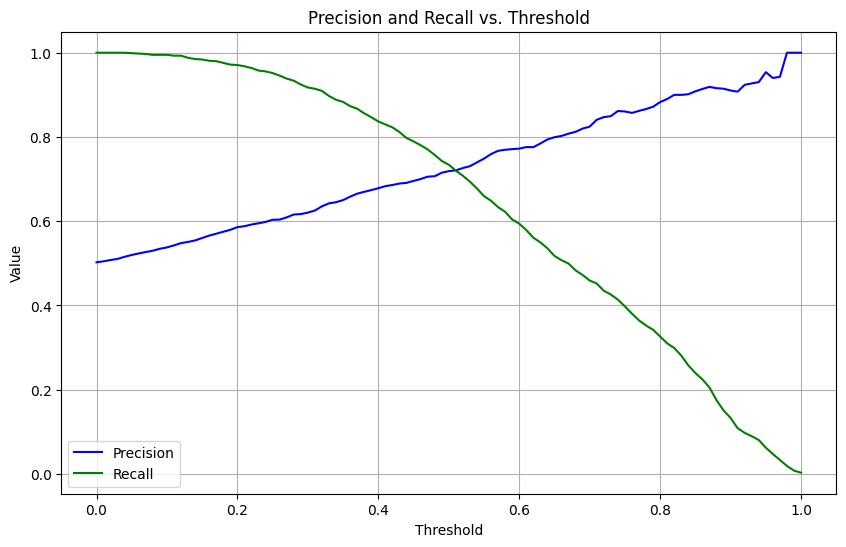

Precision and recall intersect at threshold: 0.510


In [86]:
evaluate_model(
    base_model_rf_all_feat,
    df_test, y_test
)

### Base with Features Selection

In [87]:
#_ = train_rf(
    #df_train, y_train, 
    #df_val, y_val, 
    #NUMERICAL_FEATURES_FS, CATEGORICAL_FEATURES_FS,
    #{'n_estimators':10, 'min_samples_leaf':2} # acc: 0.715 auc: 0.792
    #{'n_estimators':100, 'max_depth':6, 'random_state':42} # acc: 0.732 auc: 0.816
    #{'n_estimators':100, 'max_depth':6, 'min_samples_leaf':10, 'random_state':42} # acc: 0.733 auc: 0.815
    #{'n_estimators':100, 'max_depth':6, 'min_samples_leaf':3, 'random_state':42} # acc: 0.734 auc: 0.816
    #{'n_estimators':100, 'max_depth':8, 'min_samples_leaf':3, 'random_state':42} # acc: 0.734 auc: 0.816
    #{'n_estimators':110, 'max_depth':6, 'min_samples_leaf':1, 'random_state':42}  # acc: 0.732 auc: 0.816
    #{'n_estimators':110, 'max_depth':10, 'min_samples_leaf':10, 'min_samples_split':2,'random_state':42} # acc: 0.732 auc: 0.815
#)

In [88]:
base_trained_rf_fs_feat = train_rf(
    df_train, y_train, 
    df_val, y_val, 
    NUMERICAL_FEATURES_FS, CATEGORICAL_FEATURES_FS,
    base_param_rf
)

train: (5927, 8)
valid: (1976, 8)
RF train acc: 0.796
RF valid acc: 0.724
RF valid auc: 0.799


In [89]:
base_metrics_rf_fs_feat = base_trained_rf_fs_feat['metrics']
base_metrics_rf_fs_feat

{'train_acc': 0.7963556605365277,
 'test_acc': 0.7241902834008097,
 'test_auc': 0.7994687343394997}

In [90]:
base_model_rf_fs_feat = base_trained_rf_fs_feat['model']

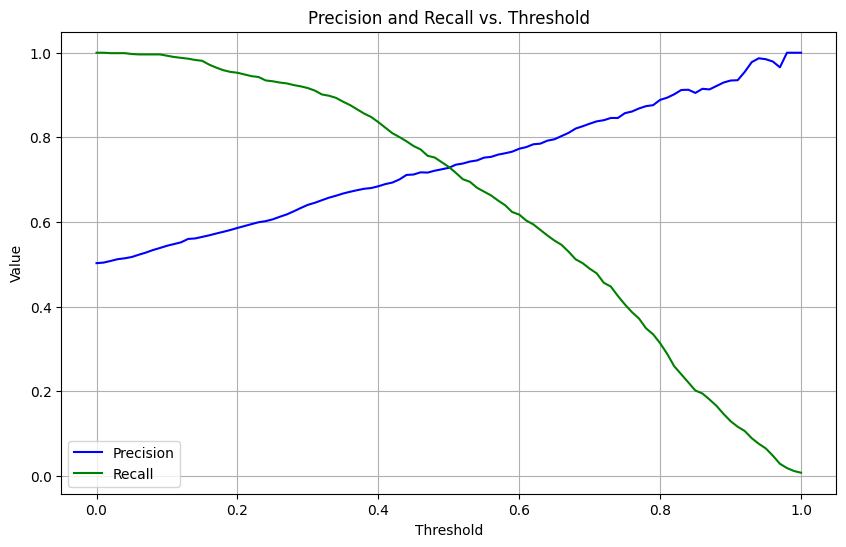

Precision and recall intersect at threshold: 0.500


In [91]:
evaluate_model(
    base_model_rf_fs_feat,
    df_test, y_test
)

### 5-Fold CV

In [92]:
def kfold_rf(
    X_train, y_train,
    numerical_features, categorical_features, 
    params_rf,
    n_splits=5
):
    # Select features
    X_train = X_train[numerical_features + categorical_features]
    print(f"train: {X_train.shape}")
    
    # Preprocessing
    transformers = []
    # Imputing categorical features)
    if categorical_features and len(categorical_features) > 0:
        transformers.append(('cat', SimpleImputer(strategy='constant', fill_value=0), categorical_features))
    # Scaling numerical features
    transformers.append(('num', StandardScaler(), numerical_features))
    preprocessor = ColumnTransformer(transformers=transformers)
    
    # Create a pipeline with preprocessing and classification
    classifier = RandomForestClassifier(**params_rf)

    # Train model
    model = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('classifier', classifier)
    ])
    
    # Perform cross-validation to evaluate the model
    scoring=['accuracy', 'roc_auc']
    scores = cross_validate(model, 
                             X_train, y_train, 
                             cv=StratifiedKFold(n_splits=n_splits), 
                             scoring=scoring)
    #print(scores)
    # Return scores
    return scores

In [93]:
kfold_scores_rf = kfold_rf(
    df_full_train, y_full_train,
    NUMERICAL_FEATURES_FS, CATEGORICAL_FEATURES_FS,
    base_param_rf
)

train: (7903, 8)


In [94]:
kfold_scores_rf_df = pd.DataFrame.from_dict(kfold_scores_rf)
kfold_scores_rf_df = kfold_scores_rf_df.sort_values(by='test_roc_auc', ascending=False)

In [95]:
kfold_scores_rf_df

,fit_time,score_time,test_accuracy,test_roc_auc
3,0.063426,0.012044,0.717089,0.798150
2,0.068168,0.011423,0.722960,0.795821
4,0.060161,0.011536,0.722152,0.795445
1,0.066625,0.011606,0.717268,0.791961
0,0.077327,0.011631,0.714105,0.784557


### Hyperparameter Tuning

In [96]:
# Function to optimize the classification model
def optimize_rf(
    X_train, y_train,
    numerical_features, categorical_features, 
    max_evals=10
):
    
    # Select features
    X_train = X_train[numerical_features + categorical_features]
    n_features = len(numerical_features + categorical_features)
    print(f"train: {X_train.shape}")
    
    # 3. Hyperparameter optimization using Hyperopt
    def objective(params):        
        # Update the pipeline with the optimized hyperparameters
        print(f"{params}")
        print(f"train: {X_train.shape}")
        
        # Preprocessing
        transformers = []
        # Imputing categorical features)
        if categorical_features and len(categorical_features) > 0:
            transformers.append(('cat', SimpleImputer(strategy='constant', fill_value=0), categorical_features))
        # Scaling numerical features
        transformers.append(('num', StandardScaler(), numerical_features))
        preprocessor = ColumnTransformer(transformers=transformers)
        
        # Create a pipeline with preprocessing and classification
        classifier = RandomForestClassifier(
            max_depth = params['max_depth'],
            #max_features = space['max_features'],
            min_samples_leaf = params['min_samples_leaf'],
            #min_samples_split = params['min_samples_split'],
            n_estimators = params['n_estimators'], 
            random_state=42
        )
    
        # Train model
        model = Pipeline(steps=[
            ('preprocess', preprocessor),
            ('classifier', classifier)
        ])
        
        # Perform cross-validation to evaluate the model
        scoring=['accuracy', #'precision_macro', 'recall_macro', 'f1_macro', 
                 'roc_auc']
        scores = cross_validate(model, 
                                 X_train, y_train, 
                                 cv=StratifiedKFold(n_splits=5), 
                                 scoring=scoring)
        #print(scores)
        
        # Loss must be minimized
        best_score = scores['test_roc_auc'].mean()
        loss = 1 - best_score
    
        # Return negative loss (Hyperopt minimizes the objective function)
        #return {'loss': -scores.mean(), 'accuracy': scores.mean(), 'auc': -auc, 'status': STATUS_OK}
        return {
            'loss': loss, 
            'params': params,
            'accuracy': scores['test_accuracy'].mean(),
            'roc_auc': scores['test_roc_auc'].mean(),
            #'precision_macro': scores['test_precision_macro'].mean(),
            #'recall_macro': scores['test_recall_macro'].mean(),
            #'f1_macro': scores['test_f1_macro'].mean(),
            'status': STATUS_OK }
    
    

    # 4. Define the search space for the hyperparameters
    # 'log_loss', 'entropy', 'gini'
    # {'n_estimators':100, 'max_depth':6, 'min_samples_leaf':3, 'random_state':42} # acc: 0.734 auc: 0.816
    space = {
        #'criterion': hp.choice('criterion', ['entropy', 'gini']),
        #'max_depth': scope.int(hp.quniform('max_depth', 10, 1200, 10)),
        'max_depth': scope.int(hp.quniform('max_depth', 2, 10, 1)),
        #'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
        #'max_features': scope.int(hp.quniform('max_features', 2, n_features, 1)),
        #'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 0.3),
        #'min_samples_leaf':  hp.choice('min_samples_leaf', [1, 2, 3, 4, 5]),
        'min_samples_leaf':  scope.int(hp.quniform('min_samples_leaf', 1, 10, 1)),
        #'min_samples_split' : hp.uniform ('min_samples_split', 0, 0.5),
        'n_estimators' : hp.choice('n_estimators', [100, 120, 140]),
        'random_state': 42
    }

    # 5. Run Hyperopt to find the best hyperparameters
    trials = Trials()
    best = fmin(fn=objective, 
                space=space, 
                algo=tpe.suggest, 
                max_evals=max_evals, 
                trials=trials)

    #print("Best hyperparameters found:", best)
    #print("Best hyperparameters found:", trials.results)

    # Results
    #history = trials.results

    # Return the evaluation metrics
    return {
        'best_params': best,
        'results': trials.results
    }

In [97]:
# Example of calling the optimization function
optimize_results_rf_fs = optimize_rf(
    df_full_train, y_full_train, 
    NUMERICAL_FEATURES_FS, CATEGORICAL_FEATURES_FS,
    max_evals=10
)


train: (7903, 8)
{'max_depth': 3, 'min_samples_leaf': 6, 'n_estimators': 140, 'random_state': 42}                                              
train: (7903, 8)                                                                                                              
{'max_depth': 4, 'min_samples_leaf': 6, 'n_estimators': 100, 'random_state': 42}                                              
train: (7903, 8)                                                                                                              
{'max_depth': 9, 'min_samples_leaf': 6, 'n_estimators': 140, 'random_state': 42}                                              
train: (7903, 8)                                                                                                              
{'max_depth': 5, 'min_samples_leaf': 4, 'n_estimators': 120, 'random_state': 42}                                              
train: (7903, 8)                                                                              

In [98]:
optimize_results_rf_fs['best_params']

{'max_depth': 5.0, 'min_samples_leaf': 4.0, 'n_estimators': 1}

In [99]:
opt_results_rf_df = pd.DataFrame.from_dict(optimize_results_rf_fs['results'])
opt_results_rf_df = opt_results_rf_df.sort_values(by='roc_auc', ascending=False)

In [100]:
opt_results_rf_df

,loss,params,accuracy,roc_auc,status
3,0.193951,"{'max_depth': 5, 'min_samples_leaf': 4, 'n_est...",0.731749,0.806049,ok
5,0.194037,"{'max_depth': 5, 'min_samples_leaf': 9, 'n_est...",0.732002,0.805963,ok
4,0.194052,"{'max_depth': 5, 'min_samples_leaf': 5, 'n_est...",0.730230,0.805948,ok
7,0.194439,"{'max_depth': 6, 'min_samples_leaf': 9, 'n_est...",0.730737,0.805561,ok
1,0.194772,"{'max_depth': 4, 'min_samples_leaf': 6, 'n_est...",0.729597,0.805228,ok
0,0.195718,"{'max_depth': 3, 'min_samples_leaf': 6, 'n_est...",0.728078,0.804282,ok
6,0.195834,"{'max_depth': 3, 'min_samples_leaf': 10, 'n_es...",0.728458,0.804166,ok
8,0.195836,"{'max_depth': 3, 'min_samples_leaf': 9, 'n_est...",0.728458,0.804164,ok
9,0.195836,"{'max_depth': 3, 'min_samples_leaf': 9, 'n_est...",0.728458,0.804164,ok
2,0.196228,"{'max_depth': 9, 'min_samples_leaf': 6, 'n_est...",0.728080,0.803772,ok


In [101]:
# Build best params xgb
#best_opt_params_rf = fs_opt_rf['best_params']
best_opt_params_rf = opt_results_rf_df.iloc[0].params
best_params_rf = {'random_state': 42}
best_params_rf = {**best_params_rf, **best_opt_params_rf}
best_params_rf

{'random_state': 42,
 'max_depth': 5,
 'min_samples_leaf': 4,
 'n_estimators': 120}

In [102]:
best_trained_rf_fs_feat = train_rf(
    df_train, y_train, 
    df_val, y_val, 
    NUMERICAL_FEATURES_FS, CATEGORICAL_FEATURES_FS,
    best_params_rf
)

train: (5927, 8)
valid: (1976, 8)
RF train acc: 0.740
RF valid acc: 0.725
RF valid auc: 0.809


In [103]:
best_metrics_xgb_fs_feat = best_trained_rf_fs_feat['metrics']
best_metrics_xgb_fs_feat

{'train_acc': 0.7403408132276025,
 'test_acc': 0.7246963562753036,
 'test_auc': 0.8085178774379139}

In [104]:
best_model_rf_fs_feat = best_trained_rf_fs_feat['model']

/home/aztleclan/.local/share/virtualenvs/ml-zoomcamp-midterm-lol-2s_EtWvW/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aztleclan/.local/share/virtualenvs/ml-zoomcamp-midterm-lol-2s_EtWvW/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aztleclan/.local/share/virtualenvs/ml-zoomcamp-midterm-lol-2s_EtWvW/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_div

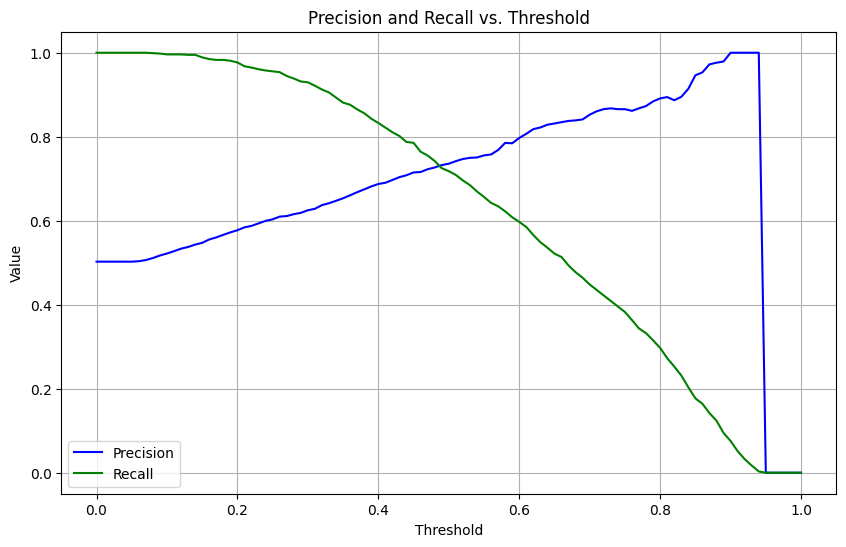

Precision and recall intersect at threshold: 0.490


In [105]:
evaluate_model(
    best_model_rf_fs_feat,
    df_test, y_test
)

### Save data

In [106]:
# Save best parameters
#with open(BEST_PARAMS_RF_FILE, 'w') as f:
#    json.dump(best_params_rf, f)

In [107]:
# Save model RF
#with open(BEST_MODEL_RF_FILE, 'wb') as file: 
    # A new file will be created 
#    pickle.dump(best_model_rf_fs_feat, file) 

In [108]:
#!ls -lh "{MODELS_DIR}"

## Train XGB

In [109]:
def train_xgb(
    X_train, y_train, #X_test, y_test,
    X_valid, y_valid,
    numerical_features, categorical_features,
    params_xgb
):   
    # Select features
    X_train = X_train[numerical_features + categorical_features]
    X_valid = X_valid[numerical_features + categorical_features]
    print(f"train: {X_train.shape}")
    print(f"valid: {X_valid.shape}")
    
    # Preprocessing
    transformers = []
    # Imputing categorical features)
    if categorical_features and len(categorical_features) > 0:
        categorical_encoder = OrdinalEncoder(
            handle_unknown="use_encoded_value", unknown_value=-1, encoded_missing_value=-1
        )
        transformers.append(('cat', SimpleImputer(strategy='constant', fill_value=0), categorical_features))
    # Scaling numerical features
    transformers.append(('num', StandardScaler(), numerical_features))
    preprocessor = ColumnTransformer(transformers=transformers)
    
    # Create a pipeline with preprocessing and classification
    classifier = xgb.XGBClassifier(**params_xgb)

    # Train model
    model = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('classifier', classifier)
    ])
    model.fit(X_train, y_train)
    
    # Evaluate model
    y_train_pred_proba = model.predict_proba(X_train)[::,1]
    y_valid_pred_proba = model.predict_proba(X_valid)[::,1]
    
    
    #calculate AUC of model
    train_acc = accuracy_score(y_train, y_train_pred_proba >= 0.5)
    test_acc = accuracy_score(y_valid, y_valid_pred_proba >= 0.5)
    test_auc = roc_auc_score(y_valid, y_valid_pred_proba)
    
    #print AUC score
    print(f"RF train acc: {train_acc:.3f}")
    print(f"RF valid acc: {test_acc:.3f}")
    print(f"RF valid auc: {test_auc:.3f}")

    return {
        'model': model,
        'metrics': {
            'train_acc': train_acc,
            'test_acc': test_acc,
            'test_auc': test_auc,
        }
    }

### Base with All Features

In [110]:
base_params_xgb = {
    'tree_method': "hist", 
    'enable_categorical': True,
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'objective': 'binary:logistic'
}

In [111]:
base_trained_xgb_all_feat = train_xgb(
    df_train, y_train, 
    df_val, y_val, 
    NUMERICAL_FEATURES, CATEGORICAL_FEATURES,
    base_params_xgb
)

train: (5927, 14)
valid: (1976, 14)
RF train acc: 0.809
RF valid acc: 0.728
RF valid auc: 0.799


In [112]:
base_metrics_xgb_all_feat = base_trained_xgb_all_feat['metrics']
base_metrics_xgb_all_feat

{'train_acc': 0.8085034587481019,
 'test_acc': 0.7277327935222672,
 'test_auc': 0.799135668483669}

In [113]:
base_model_xgb_all_feat = base_trained_xgb_all_feat['model']

/home/aztleclan/.local/share/virtualenvs/ml-zoomcamp-midterm-lol-2s_EtWvW/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


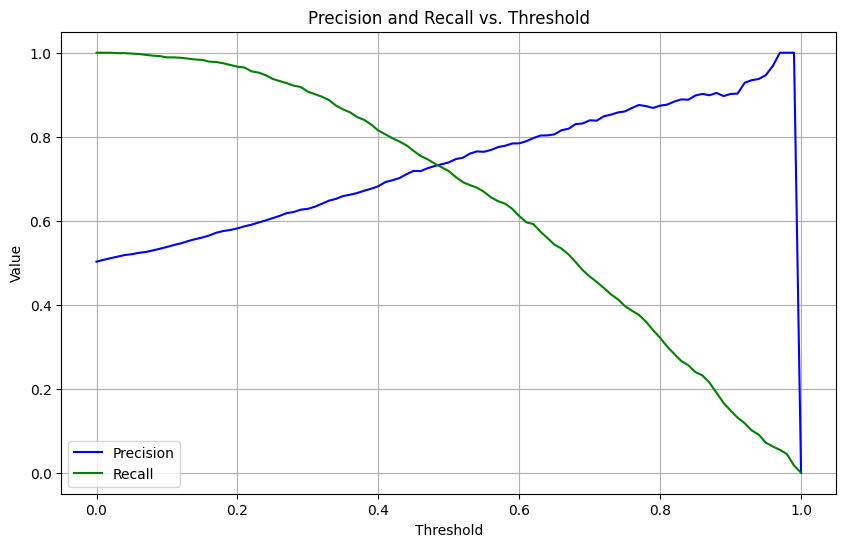

Precision and recall intersect at threshold: 0.480


In [114]:
evaluate_model(
    base_model_xgb_all_feat,
    df_test, y_test
)

### Base with Features Selection

In [115]:
base_params_xgb = {
    'tree_method': "hist", 
    'enable_categorical': True,
    'max_depth': 6,
    'learning_rate': 0.1,
    'n_estimators': 100,
    'objective': 'binary:logistic'
}

In [116]:
base_trained_xgb_fs_feat = train_xgb(
    df_train, y_train, 
    df_val, y_val, 
    NUMERICAL_FEATURES_FS, CATEGORICAL_FEATURES_FS,
    base_params_xgb
)

train: (5927, 8)
valid: (1976, 8)
RF train acc: 0.796
RF valid acc: 0.730
RF valid auc: 0.802


In [117]:
base_metrics_xgb_fs_feat = base_trained_xgb_fs_feat['metrics']
base_metrics_xgb_fs_feat

{'train_acc': 0.7960182216973174,
 'test_acc': 0.729757085020243,
 'test_auc': 0.8023464233338764}

In [118]:
base_model_xgb_fs_feat = base_trained_xgb_fs_feat['model']

/home/aztleclan/.local/share/virtualenvs/ml-zoomcamp-midterm-lol-2s_EtWvW/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


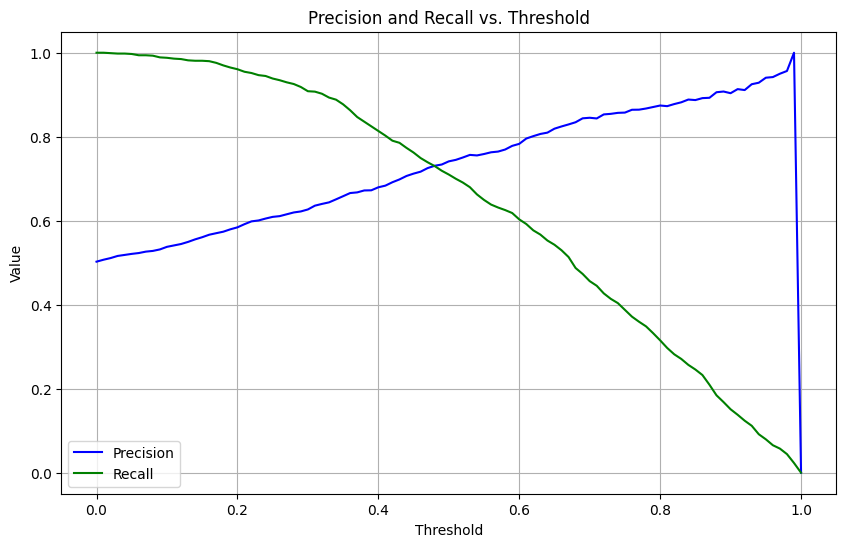

Precision and recall intersect at threshold: 0.480


In [119]:
evaluate_model(
    base_model_xgb_fs_feat,
    df_test, y_test
)

### 5-Fold CV

In [120]:
def kfold_xgb(
    X_train, y_train,
    numerical_features, categorical_features, 
    params_xgb,
    n_splits=5
):
    # Select features
    X_train = X_train[numerical_features + categorical_features]
    print(f"train: {X_train.shape}")
    
    # Preprocessing
    transformers = []
    # Imputing categorical features)
    if categorical_features and len(categorical_features) > 0:
        transformers.append(('cat', SimpleImputer(strategy='constant', fill_value=0), categorical_features))
    # Scaling numerical features
    transformers.append(('num', StandardScaler(), numerical_features))
    preprocessor = ColumnTransformer(transformers=transformers)
    
    # Create a pipeline with preprocessing and classification
    classifier = xgb.XGBClassifier(**params_xgb)

    # Train model
    model = Pipeline(steps=[
        ('preprocess', preprocessor),
        ('classifier', classifier)
    ])
    
    # Perform cross-validation to evaluate the model
    scoring=['accuracy', 'roc_auc']
    scores = cross_validate(model, 
                             X_train, y_train, 
                             cv=StratifiedKFold(n_splits=n_splits), 
                             scoring=scoring)
    #print(scores)
    # Return scores
    return scores

In [121]:
kfold_scores_xgb = kfold_xgb(
    df_full_train, y_full_train,
    NUMERICAL_FEATURES_FS, CATEGORICAL_FEATURES_FS,
    base_params_xgb
)

train: (7903, 8)


In [122]:
kfold_scores_xgb_df = pd.DataFrame.from_dict(kfold_scores_xgb)
kfold_scores_xgb_df = kfold_scores_xgb_df.sort_values(by='test_roc_auc', ascending=False)

In [123]:
kfold_scores_xgb_df

,fit_time,score_time,test_accuracy,test_roc_auc
3,0.070408,0.012947,0.739873,0.808840
4,0.080822,0.012838,0.721519,0.799114
2,0.077175,0.012739,0.717268,0.793198
1,0.070499,0.014881,0.726123,0.790612
0,0.088907,0.012849,0.716635,0.784182


### Hyperparameter Tuning

In [124]:
# Function to optimize the classification model
def optimize_xgb(
    X_train, y_train,
    numerical_features, categorical_features, 
    max_evals=10
):
    
    # Select features
    X_train = X_train[numerical_features + categorical_features]
    n_features = len(numerical_features + categorical_features)
    print(f"train: {X_train.shape}")
    
    # 3. Hyperparameter optimization using Hyperopt
    def objective(params):
        # Update the pipeline with the optimized hyperparameters
        #print(f"{params}")
        #print(f"train: {X_train.shape}")
        
        # Preprocessing
        transformers = []
        # Imputing categorical features)
        if categorical_features and len(categorical_features) > 0:
            transformers.append(('cat', SimpleImputer(strategy='constant', fill_value=0), categorical_features))
        # Scaling numerical features
        transformers.append(('num', StandardScaler(), numerical_features))
        preprocessor = ColumnTransformer(transformers=transformers)
        
        # Create a pipeline with preprocessing and classification
        classifier = xgb.XGBClassifier(
            n_estimators=int(params['n_estimators']),
            max_depth=int(params['max_depth']),
            learning_rate=params['learning_rate'],
            #subsample=params['subsample'],
            colsample_bytree=params['colsample_bytree'],
            #min_child_weight=int(params['min_child_weight']),
            gamma=params['gamma'],
            #reg_alpha=params['reg_alpha'],
            #reg_lambda=params['reg_lambda'],
            objective='binary:logistic',  # Define this depending on tu objetivo
            #use_label_encoder=False,  # Disabling the deprecation warning
            eval_metric='logloss',  # Avoid warning
            random_state=42 
        )
    
        # Train model
        model = Pipeline(steps=[
            ('preprocess', preprocessor),
            ('classifier', classifier)
        ])
        
        # Perform cross-validation to evaluate the model
        scoring=['accuracy',
                 'roc_auc']
        scores = cross_validate(model, 
                                 X_train, y_train, 
                                 cv=StratifiedKFold(n_splits=5), 
                                 scoring=scoring)
        #print(scores)
        
        # Loss must be minimized
        best_score = scores['test_roc_auc'].mean()
        loss = 1 - best_score
    
        # Return negative loss (Hyperopt minimizes the objective function)
        return {
            'loss': loss, 
            'params': params,
            'accuracy': scores['test_accuracy'].mean(),
            'roc_auc': scores['test_roc_auc'].mean(),
            'status': STATUS_OK }
    
    

    # 4. Define the search space for the hyperparameters
    space = {
        'n_estimators': scope.int(hp.quniform('n_estimators', 50, 200, 50)),  # Number of trees
        'max_depth': scope.int(hp.quniform('max_depth', 3, 15, 1)),  # Maximum depth of each tree
        'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),  # Learning rate
        #'subsample': hp.uniform('subsample', 0.5, 1.0),  # Fraction of data used for each tree
        'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 0.9),  # Fraction of features used for each tree
        #'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),  # Minimum sum of instance weight
        'gamma': hp.uniform('gamma', 0, 0.5),  # Minimum loss reduction for a split
        #'reg_alpha': hp.uniform('reg_alpha', 0, 1),  # L1 regularization term
        #'reg_lambda': hp.uniform('reg_lambda', 0, 1)  # L2 regularization term
    }

    # 5. Run Hyperopt to find the best hyperparameters
    trials = Trials()
    best = fmin(fn=objective, 
                space=space, 
                algo=tpe.suggest, 
                max_evals=max_evals, 
                trials=trials)

    #print("Best hyperparameters found:", best)
    #print("Best hyperparameters found:", trials.results)
    
    # Return the evaluation metrics
    return {
        'best_params': best,
        'results': trials.results
    }

In [125]:
# Example of calling the optimization function
optimize_results_xgb_fs = optimize_xgb(
    df_full_train, y_full_train, 
    NUMERICAL_FEATURES_FS, CATEGORICAL_FEATURES_FS,
    max_evals=20
)

train: (7903, 8)
100%|██████████████████████████████████████████████████████| 20/20 [00:14<00:00,  1.35trial/s, best loss: 0.19861645630324498]


In [126]:
opt_results_xgb_df = pd.DataFrame.from_dict(optimize_results_xgb_fs['results'])
opt_results_xgb_df = opt_results_xgb_df.sort_values(by='roc_auc', ascending=False)

In [127]:
opt_results_xgb_df

,loss,params,accuracy,roc_auc,status
15,0.198616,"{'colsample_bytree': 0.83839024060354, 'gamma'...",0.726814,0.801384,ok
7,0.199359,"{'colsample_bytree': 0.7208117370682476, 'gamm...",0.726814,0.800641,ok
13,0.201238,"{'colsample_bytree': 0.630950246438535, 'gamma...",0.721625,0.798762,ok
0,0.205737,"{'colsample_bytree': 0.6449826079635278, 'gamm...",0.718715,0.794263,ok
14,0.207333,"{'colsample_bytree': 0.5549129047287877, 'gamm...",0.717326,0.792667,ok
12,0.210783,"{'colsample_bytree': 0.6818793465734149, 'gamm...",0.715679,0.789217,ok
3,0.214337,"{'colsample_bytree': 0.5999631747625309, 'gamm...",0.709226,0.785663,ok
17,0.215036,"{'colsample_bytree': 0.5709152378452327, 'gamm...",0.709351,0.784964,ok
16,0.215924,"{'colsample_bytree': 0.56341869359892, 'gamma'...",0.706442,0.784076,ok
11,0.217352,"{'colsample_bytree': 0.8168767590517416, 'gamm...",0.711756,0.782648,ok


In [128]:
# Build best params xgb
#best_opt_params_xgb = optimize_results_rf_fs['best_params']
best_opt_params_xgb = opt_results_xgb_df.iloc[0].params
best_params_xgb = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'random_state': 42
}
best_params_xgb = {**best_params_xgb, **best_opt_params_xgb}
best_params_xgb

{'objective': 'binary:logistic',
 'eval_metric': 'logloss',
 'random_state': 42,
 'colsample_bytree': 0.83839024060354,
 'gamma': 0.4005401180966643,
 'learning_rate': 0.03339778422024146,
 'max_depth': 7,
 'n_estimators': 50}

In [129]:
best_trained_xgb_fs_feat = train_xgb(
    df_full_train, y_full_train, 
    df_test, y_test, 
    NUMERICAL_FEATURES_FS, CATEGORICAL_FEATURES_FS,
    best_params_xgb
)

train: (7903, 8)
valid: (1976, 8)
RF train acc: 0.776
RF valid acc: 0.724
RF valid auc: 0.812


In [130]:
best_metrics_xgb_fs_feat = best_trained_xgb_fs_feat['metrics']
best_metrics_xgb_fs_feat

{'train_acc': 0.7756548146273567,
 'test_acc': 0.7241902834008097,
 'test_auc': 0.8124198996228944}

In [131]:
best_model_xgb_fs_feat = best_trained_xgb_fs_feat['model']

/home/aztleclan/.local/share/virtualenvs/ml-zoomcamp-midterm-lol-2s_EtWvW/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aztleclan/.local/share/virtualenvs/ml-zoomcamp-midterm-lol-2s_EtWvW/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/aztleclan/.local/share/virtualenvs/ml-zoomcamp-midterm-lol-2s_EtWvW/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_div

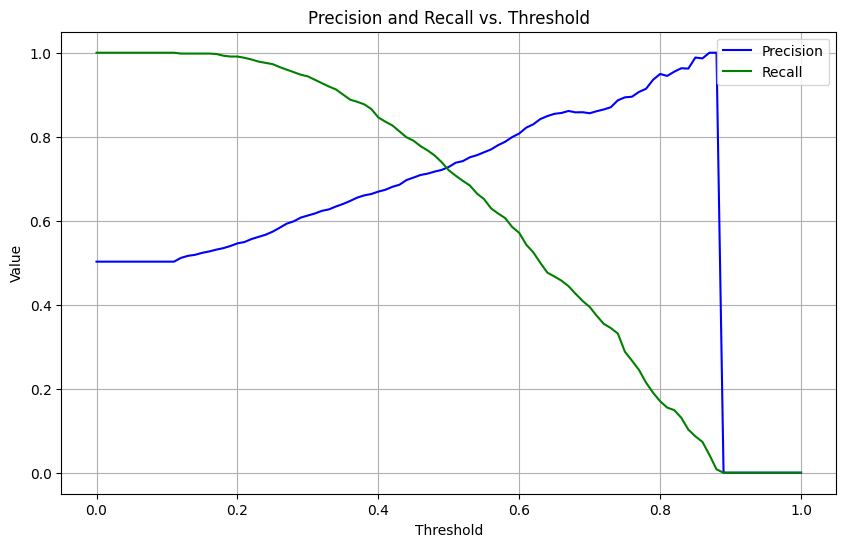

Precision and recall intersect at threshold: 0.500


In [132]:
evaluate_model(
    best_model_xgb_fs_feat,
    df_test, y_test
)

### Save data

In [133]:
# Save best parameters
#with open(BEST_PARAMS_XGB_FILE, 'w') as f:
#    json.dump(best_params_xgb, f)

In [134]:
# Save model RF
#with open(BEST_MODEL_XGB_FILE, 'wb') as file: 
    # A new file will be created 
#    pickle.dump(best_model_xgb_fs_feat, file) 

In [135]:
#!ls -lh "{MODELS_DIR}"